# MATCH OUTCOME ANALYSES & PREDICTIONS

## Author

Saban Akay, 14045645

## Introduction

### Background Information

### Data Description

The Europian Soccer Dataset is a relational database of soccer matches, players, and teams. It contains data for soccer matches in eleven European countries from 2008 to 2016. The database contains;
- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matchesThe data is stored in a SQLite database.

The database is provided by [Hugomathien](https://www.kaggle.com/hugomathien/soccer) on Kaggle.

### Problem Statement

In this notebook, I will try to answer the following questions:

1. What is the most common match outcome?
2. What is the relationship between the match outcome and the team attributes?
3. What is the relationship between the match outcome and the player attributes?
4. What is the relationship between the match outcome and the betting odds?
5. Which relationship is the strongest predictor of the match outcome?


### Methodology

The methodology of this notebook is as follows:

1. [Setup](#Setup)
    - [Import Libraries](#Import-Libraries)
    - [Ultilities](#Ultilities)
2. [Data Preparation](#Data-Preparation)
    - [Data Collection](#Data-Collection)
    - [Data Cleaning](#Data-Cleaning)
    - [Data Transformation](#Data-Transformation)
        - [Betting Odds](#Betting-Odds)
        - [Team Attributes](#Team-Attributes)
        - [Player Attributes](#Player-Attributes)
3. [Data Analysis](#Data-Analysis)
    - [Descriptive Statistics](#Descriptive-Statistics)
    - [Data Visualization](#Data-Visualization)
    - [Identifying Patterns and Insights](#Identifying-Patterns-and-Insights)
4. [Prediction](#Prediction)
    - [Model Definition](#Model-Definition)
    - [Model Evaluation](#Model-Evaluation)
5. [Conclusion](#Conclusion)
    - [Discussion](#Discussion)
    - [Limitations](#Limitations)
    - [Future Work](#Future-Work)

## Setup

### Import Libraries

In [1647]:
# Import required libraries
import sqlite3 as db
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from time import time
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings
import tempfile
from joblib import Memory
import datetime
import missingno as msno
import scipy.stats as stats

### Ultilities

In [1648]:
warnings.filterwarnings("ignore")

In [1649]:
# seed for reproducibility
Seed = 42

In [1650]:
# Create a temporary folder to store the transformers of the pipeline
location = tempfile.gettempdir()
memory = Memory(location=location, verbose=-1)
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [1651]:
# amount of data to be used (for run time purposes, 100% = 1, 50% = 0.5, etc.)
run = 0.02
n = 0.3

In [1652]:
relations = ['betting', 'team', 'player']

## Data Preparation

In this section, we will load and clean the data from the European Soccer Database. 
This may include handling missing values, removing irrelevant columns, and merging different tables of the database.

### Data Collection

In [1653]:
# explore the tables in the database
conn = db.connect('../data/database.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [1654]:
# load the data
with db.connect('../data/database.sqlite') as conn:
    matches = pd.read_sql_query('SELECT * FROM Match', conn)
    teams = pd.read_sql_query('SELECT * FROM Team', conn)
    leagues = pd.read_sql_query('SELECT * FROM League', conn)
    countries = pd.read_sql_query('SELECT * FROM Country', conn)
    players = pd.read_sql_query('SELECT * FROM Player', conn)
    player_attributes = pd.read_sql_query('SELECT * FROM Player_Attributes', conn)
    team_attributes = pd.read_sql_query('SELECT * FROM Team_Attributes', conn)


In [1655]:
# explore the columns in matches table
print(f'{matches.columns.values} \t {matches.shape}')

['id' 'country_id' 'league_id' 'season' 'stage' 'date' 'match_api_id'
 'home_team_api_id' 'away_team_api_id' 'home_team_goal' 'away_team_goal'
 'home_player_X1' 'home_player_X2' 'home_player_X3' 'home_player_X4'
 'home_player_X5' 'home_player_X6' 'home_player_X7' 'home_player_X8'
 'home_player_X9' 'home_player_X10' 'home_player_X11' 'away_player_X1'
 'away_player_X2' 'away_player_X3' 'away_player_X4' 'away_player_X5'
 'away_player_X6' 'away_player_X7' 'away_player_X8' 'away_player_X9'
 'away_player_X10' 'away_player_X11' 'home_player_Y1' 'home_player_Y2'
 'home_player_Y3' 'home_player_Y4' 'home_player_Y5' 'home_player_Y6'
 'home_player_Y7' 'home_player_Y8' 'home_player_Y9' 'home_player_Y10'
 'home_player_Y11' 'away_player_Y1' 'away_player_Y2' 'away_player_Y3'
 'away_player_Y4' 'away_player_Y5' 'away_player_Y6' 'away_player_Y7'
 'away_player_Y8' 'away_player_Y9' 'away_player_Y10' 'away_player_Y11'
 'home_player_1' 'home_player_2' 'home_player_3' 'home_player_4'
 'home_player_5' 'home_pl

In [1656]:
# explore the columns in countries table
print(f'{countries.columns.values} \t {countries.shape}')

['id' 'name'] 	 (11, 2)


In [1657]:
# explore the columns in leagues table
print(f'{leagues.columns.values} \t {leagues.shape}')

['id' 'country_id' 'name'] 	 (11, 3)


In [1658]:
# explore the columns in players table
print(f'{players.columns.values} \t {players.shape}')

['id' 'player_api_id' 'player_name' 'player_fifa_api_id' 'birthday'
 'height' 'weight'] 	 (11060, 7)


In [1659]:
# explore the columns in player_attributes table
print(f'{player_attributes.columns.values} \t {player_attributes.shape}')

['id' 'player_fifa_api_id' 'player_api_id' 'date' 'overall_rating'
 'potential' 'preferred_foot' 'attacking_work_rate' 'defensive_work_rate'
 'crossing' 'finishing' 'heading_accuracy' 'short_passing' 'volleys'
 'dribbling' 'curve' 'free_kick_accuracy' 'long_passing' 'ball_control'
 'acceleration' 'sprint_speed' 'agility' 'reactions' 'balance'
 'shot_power' 'jumping' 'stamina' 'strength' 'long_shots' 'aggression'
 'interceptions' 'positioning' 'vision' 'penalties' 'marking'
 'standing_tackle' 'sliding_tackle' 'gk_diving' 'gk_handling' 'gk_kicking'
 'gk_positioning' 'gk_reflexes'] 	 (183978, 42)


In [1660]:
# explore the columns in teams table
print(f'{teams.columns.values} \t {teams.shape}')

['id' 'team_api_id' 'team_fifa_api_id' 'team_long_name' 'team_short_name'] 	 (299, 5)


In [1661]:
# explore the columns in team_attributes table
print(f'{team_attributes.columns.values} \t {team_attributes.shape}')

['id' 'team_fifa_api_id' 'team_api_id' 'date' 'buildUpPlaySpeed'
 'buildUpPlaySpeedClass' 'buildUpPlayDribbling'
 'buildUpPlayDribblingClass' 'buildUpPlayPassing'
 'buildUpPlayPassingClass' 'buildUpPlayPositioningClass'
 'chanceCreationPassing' 'chanceCreationPassingClass'
 'chanceCreationCrossing' 'chanceCreationCrossingClass'
 'chanceCreationShooting' 'chanceCreationShootingClass'
 'chanceCreationPositioningClass' 'defencePressure' 'defencePressureClass'
 'defenceAggression' 'defenceAggressionClass' 'defenceTeamWidth'
 'defenceTeamWidthClass' 'defenceDefenderLineClass'] 	 (1458, 25)


In [1662]:
def get_match_outcome(df: pd.DataFrame):
    """
    This function takes a dataframe and returns a dataframe with a new column
    called 'outcome' which is the outcome of the match.

    Roadmap
    -------
    1. Create a new column called 'outcome' and set it to 0
    2. Set the value of 'outcome' to 1 if the home_team_goal is greater than the away_team_goal
    3. Set the value of 'outcome' to -1 if the home_team_goal is less than the away_team_goal
    4. If the home_team_goal is equal to the away_team_goal or there is no goal scored, the value of 'outcome' is already 0

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the match data
        
    Returns
    -------
    pd.DataFrame
        The dataframe with the new column 'outcome'
    """
    # create a new column called 'outcome' and set it to 0
    # set the value of 'outcome' to 1 if the home_team_goal is greater than the away_team_goal
    # set the value of 'outcome' to -1 if the home_team_goal is less than the away_team_goal
    if df['home_team_goal'] > df['away_team_goal']:
        df['outcome'] = 1
    elif df['home_team_goal'] < df['away_team_goal']:
        df['outcome'] = -1
    else:
        df['outcome'] = 0
    # if the home_team_goal is equal to the away_team_goal or there is no goal scored, the value of 'outcome' is already 0
    return df['outcome']

In [1663]:
def get_player_features(df: pd.DataFrame, player_attributes: pd.DataFrame):
    """
    This function takes a dataframe row and a dataframe with player attributes 
    and returns a dataframe with the player features.

    Roadmap
    -------
    1. Get the match id, home team id, away team id and date
    2. Get the result of the match
    3. Create an empty dataframe to store the player features
    4. For each player in the home team, get the player attributes for the last match
    5. For each player in the away team, get the player attributes for the last match
    6. Return the dataframe with the player features

    Parameters
    ----------
    df : pd.DataFrame
        A dataframe row with the match information
    player_attributes : pd.DataFrame
        A dataframe with the player attributes

    Returns
    -------
    pd.DataFrame
        A dataframe with the player features
    """
    # get the match id, home team id, away team id, league id and date
    home_team_id = df['home_team_api_id']
    away_team_id = df['away_team_api_id']
    date = df['date']
    # get the result of the match
    outcome = get_match_outcome(df)

    # create an empty dataframe to store the player features
    features = pd.DataFrame()
    # for each player in the home team, get the player attributes for the last match
    for i in range(1, 12):
        # get the player id
        player_id = df[f'home_player_{i}']

        # get the player attributes for the last match
        attributes = player_attributes[player_attributes.player_api_id == player_id]
        current_attributes = attributes[attributes.date < date].sort_values(by='date', ascending=False)[:1]

        if not current_attributes.empty:
            # add the player attributes to the dataframe with suffix starting with 'home_player_{i}_'
            for col in current_attributes.columns:
                if col not in ['id', 'player_fifa_api_id', 'player_api_id', 'date']:
                    name = f'home_player_{i}_{col}'
                    value = current_attributes[col].values[0]
                    features.loc[0, name] = value
        else:
            for col in current_attributes.columns:
                if col not in ['id', 'player_fifa_api_id', 'player_api_id', 'date']:
                    name = f'home_player_{i}_{col}'
                    features.loc[0, name] = np.nan
    # for each player in the away team, get the player attributes for the last match
    for i in range(1, 12):
        # get the player id
        player_id = df[f'away_player_{i}']

        # get the player attributes for the last match
        attributes = player_attributes[player_attributes.player_api_id == player_id]
        current_attributes = attributes[attributes.date < date].sort_values(by='date', ascending=False)[:1]

        if not current_attributes.empty:
            # add the player attributes to the dataframe with suffix starting with 'away_player_{i}_'
            for col in current_attributes.columns:
                if col not in ['id', 'player_fifa_api_id', 'player_api_id', 'date']:
                    name = f'away_player_{i}_{col}'
                    value = current_attributes[col].values[0]
                    features.loc[0, name] = value
        else:
            for col in current_attributes.columns:
                if col not in ['id', 'player_fifa_api_id', 'player_api_id', 'date']:
                    name = f'away_player_{i}_{col}'
                    features.loc[0, name] = np.nan

    # collect all the attributes in a dataframe with the match outcome
    features.loc[0, 'outcome'] = outcome

    features.reset_index(drop=True, inplace=True)

    return features.iloc[0]

In [1664]:
def get_team_features(df: pd.DataFrame, team_attributes: pd.DataFrame):
    """
    This function takes a dataframe row and a dataframe with team attributes 
    and returns a dataframe with the team features.

    Roadmap
    -------
    1. Get the home team id, away team id and date
    2. Get the result of the match
    3. Create an empty dataframe to store the team features
    4. Get the home team attributes for the last match
    5. Get the away team attributes for the last match
    6. Return the dataframe with the team features
    
    Parameters
    ----------
    df : pd.DataFrame
        A dataframe row with the match information
    team_attributes : pd.DataFrame
        A dataframe with the team attributes

    Returns
    -------
    pd.DataFrame
        A dataframe with the team features
    """
    # get the match id, home team id, away team id, league id and date
    home_team_id = df['home_team_api_id']
    away_team_id = df['away_team_api_id']
    date = df['date']

    # get the result of the match
    outcome = get_match_outcome(df)

    # create an empty dataframe to store the team features
    features = pd.DataFrame()
    # get the home team attributes for the last match
    home_attributes = team_attributes[team_attributes.team_api_id == home_team_id]
    home_current_attributes = home_attributes[home_attributes.date < date].sort_values(by='date', ascending=False)[:1]
    if not home_current_attributes.empty:
        # add the team attributes to the dataframe with suffix starting with 'home_team_'
        for col in home_current_attributes.columns:
            if col not in ['id', 'team_fifa_api_id', 'team_api_id', 'date']:
                name = f'home_team_{col}'
                value = home_current_attributes[col].values[0]
                features.loc[0, name] = value
    else:
        for col in home_current_attributes.columns:
            if col not in ['id', 'team_fifa_api_id', 'team_api_id', 'date']:
                name = f'home_team_{col}'
                features.loc[0, name] = np.nan

    # get the away team attributes for the last match
    away_attributes = team_attributes[team_attributes.team_api_id == away_team_id]
    away_current_attributes = away_attributes[away_attributes.date < date].sort_values(by='date', ascending=False)[:1]
    if not away_current_attributes.empty:
        # add the team attributes to the dataframe with suffix starting with 'away_team_'
        for col in away_current_attributes.columns:
            if col not in ['id', 'team_fifa_api_id', 'team_api_id', 'date']:
                name = f'away_team_{col}'
                value = away_current_attributes[col].values[0]
                features.loc[0, name] = value
    else:
        for col in away_current_attributes.columns:
            if col not in ['id', 'team_fifa_api_id', 'team_api_id', 'date']:
                name = f'away_team_{col}'
                features.loc[0, name] = np.nan

    # collect all the attributes in a dataframe with the match outcome
    features.loc[0, 'outcome'] = outcome

    features.reset_index(drop=True, inplace=True)
    
    return features.iloc[0]

In [1665]:
def get_odds_features(df: pd.DataFrame):
    """
    This function takes a dataframe row and returns a dataframe with the odds features.

    Roadmap
    -------
    1. Get the match id, home team id, away team id, league id and date.
    2. Get the result of the match.
    3. Create an empty dataframe to store the odds features.
    4. Add the odds attributes to the dataframe.
    5. Collect all the attributes in a dataframe with the match id, home team id, away team id, league id, date and match outcome.
    6. Return the dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        A dataframe row with the match details.

    Returns
    -------
    pd.DataFrame
        A dataframe with the odds features.
    """
    # get the match id, home team id, away team id, league id and date
    match_id = df['match_api_id']
    home_team_id = df['home_team_api_id']
    away_team_id = df['away_team_api_id']
    league_id = df['league_id']
    date = df['date']

    # get the result of the match
    outcome = get_match_outcome(df)

    # create an empty dataframe to store the odds features
    features = pd.DataFrame()
    # add the odds attributes to the dataframe
    for col in df.index:
        if col.startswith('B365') or col.startswith('BW') or col.startswith('IW') or col.startswith('LB') or col.startswith('PS') or col.startswith('WH') or col.startswith('SJ') or col.startswith('VC') or col.startswith('GB') or col.startswith('BS'):
            name = col
            value = df[col]
            features.loc[0, name] = value

    # collect all the attributes in a dataframe with the match outcome
    features.loc[0, 'outcome'] = outcome

    features.reset_index(drop=True, inplace=True)

    end = time()

    return features.iloc[0]

In [1666]:
# take only 1% rows of data for run time purposes
matches = matches.sample(frac=run, random_state=Seed)
matches.shape

(520, 115)

In [1667]:
start = time()
#  get betting odds for the matches
mf_betting = matches.apply(get_odds_features, axis=1)
end = time()
print(f'Getting betting odds features took {round(end - start, 2)} seconds')
mf_betting.info()

Getting betting odds features took 1.95 seconds
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 13049 to 14767
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   B365H    457 non-null    float64
 1   B365D    457 non-null    float64
 2   B365A    457 non-null    float64
 3   BWH      457 non-null    float64
 4   BWD      457 non-null    float64
 5   BWA      457 non-null    float64
 6   IWH      456 non-null    float64
 7   IWD      456 non-null    float64
 8   IWA      456 non-null    float64
 9   LBH      455 non-null    float64
 10  LBD      455 non-null    float64
 11  LBA      455 non-null    float64
 12  PSH      227 non-null    float64
 13  PSD      227 non-null    float64
 14  PSA      227 non-null    float64
 15  WHH      456 non-null    float64
 16  WHD      456 non-null    float64
 17  WHA      456 non-null    float64
 18  SJH      344 non-null    float64
 19  SJD      344 non-null    float64
 20  

In [1668]:
start = time()
# get player attributes for the matches
mf_player = matches.apply(get_player_features, axis=1, args=(player_attributes,))
end = time()
print(f'Player attributes extracted in {round(end - start, 2)} seconds')
mf_player.info()

Player attributes extracted in 77.29 seconds
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 13049 to 14767
Columns: 837 entries, home_player_1_overall_rating to outcome
dtypes: float64(771), object(66)
memory usage: 3.3+ MB


In [1669]:
start = time()
# get team attributes for the matches
mf_team = matches.apply(get_team_features, axis=1, args=(team_attributes,))
end = time()
print(f'Getting team attributes features took {round(end - start, 2)} seconds')
mf_team.info()

Getting team attributes features took 3.43 seconds
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 13049 to 14767
Data columns (total 43 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   home_team_buildUpPlaySpeed                408 non-null    float64
 1   home_team_buildUpPlaySpeedClass           408 non-null    object 
 2   home_team_buildUpPlayDribbling            116 non-null    float64
 3   home_team_buildUpPlayDribblingClass       408 non-null    object 
 4   home_team_buildUpPlayPassing              408 non-null    float64
 5   home_team_buildUpPlayPassingClass         408 non-null    object 
 6   home_team_buildUpPlayPositioningClass     408 non-null    object 
 7   home_team_chanceCreationPassing           408 non-null    float64
 8   home_team_chanceCreationPassingClass      408 non-null    object 
 9   home_team_chanceCreationCrossing          408 non-nu

### Data Cleaning

The irrelevant columns are removed already in the previous section, so there will only be handling the missing values in this section.

In [1670]:
def data_cleaning(df: pd.DataFrame):
    """
    This function takes a dataframe and a list of columns to drop and returns a cleaned dataframe.

    Roadmap
    -------
    1. Check the distribution of the missing values in the dataframe
    2. Check the percentage of missing values in per column and sort them
    3. Check the matrix figure of missing values in the dataframe (via msno.matrix)
    4. Drop the columns with more than 30% missing values
    5. Drop the rows with infinite values.
    6. Drop the rows with zero values.
    7. Drop the rows with missing values.
    8. Return the cleaned dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        A dataframe with the features.

    Returns
    -------
    pd.DataFrame
        A cleaned dataframe.
    """

    # copy the dataframe
    df = df.copy()

    # print the shape of the dataframe
    print(f'The shape of the dataframe is {df.shape} before cleaning. \n')

    # check the distribution of the missing values in the dataframe
    print(f'The distribution of the missing values in the dataframe is: \n'
        f'{df.isnull().sum().sort_values(ascending=False)} \n')

    # check the percentage of missing values in per column and sort them
    print(f'The percentage of missing values in per column and sorted is: \n'
        f'{(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)} \n')

    # check the matrix figure of missing values in the dataframe (via msno.matrix)
    # name the figure and the size
    print(msno.matrix(df, figsize=(20, 20), fontsize=8, color=(0.42, 0.1, 0.05)))

    print(f'\n Dropping the columns with more than 30% missing values. \n'
        f' Dropped columns are: \n'
        f'{df.columns[df.isnull().mean() > 0.3]} \n')

    # drop the columns with more than 30% missing values
    df.dropna(axis=1, thresh=0.7 * len(df), inplace=True)

    print(f'\n The shape of the dataframe is {df.shape} after cleaning columns with more than 30% missing values. \n')

    # drop the rows with missing values
    df.dropna(inplace=True)
    print(f'\n The shape of the dataframe is {df.shape} after cleaning rows with missing values. \n')

    print(f'\n The shape of the dataframe is {df.shape} after overall cleaning. \n')

    return df


The shape of the dataframe is (520, 31) before cleaning. 

The distribution of the missing values in the dataframe is: 
PSH        293
PSA        293
PSD        293
GBH        236
BSA        236
BSD        236
BSH        236
GBA        236
GBD        236
SJA        176
SJD        176
SJH        176
LBA         65
LBD         65
LBH         65
WHD         64
WHA         64
IWA         64
IWD         64
IWH         64
WHH         64
VCA         63
B365H       63
VCD         63
VCH         63
B365D       63
BWA         63
BWD         63
BWH         63
B365A       63
outcome      0
dtype: int64 

The percentage of missing values in per column and sorted is: 
PSH        56.346154
PSA        56.346154
PSD        56.346154
GBH        45.384615
BSA        45.384615
BSD        45.384615
BSH        45.384615
GBA        45.384615
GBD        45.384615
SJA        33.846154
SJD        33.846154
SJH        33.846154
LBA        12.500000
LBD        12.500000
LBH        12.500000
WHD        12.307692
W

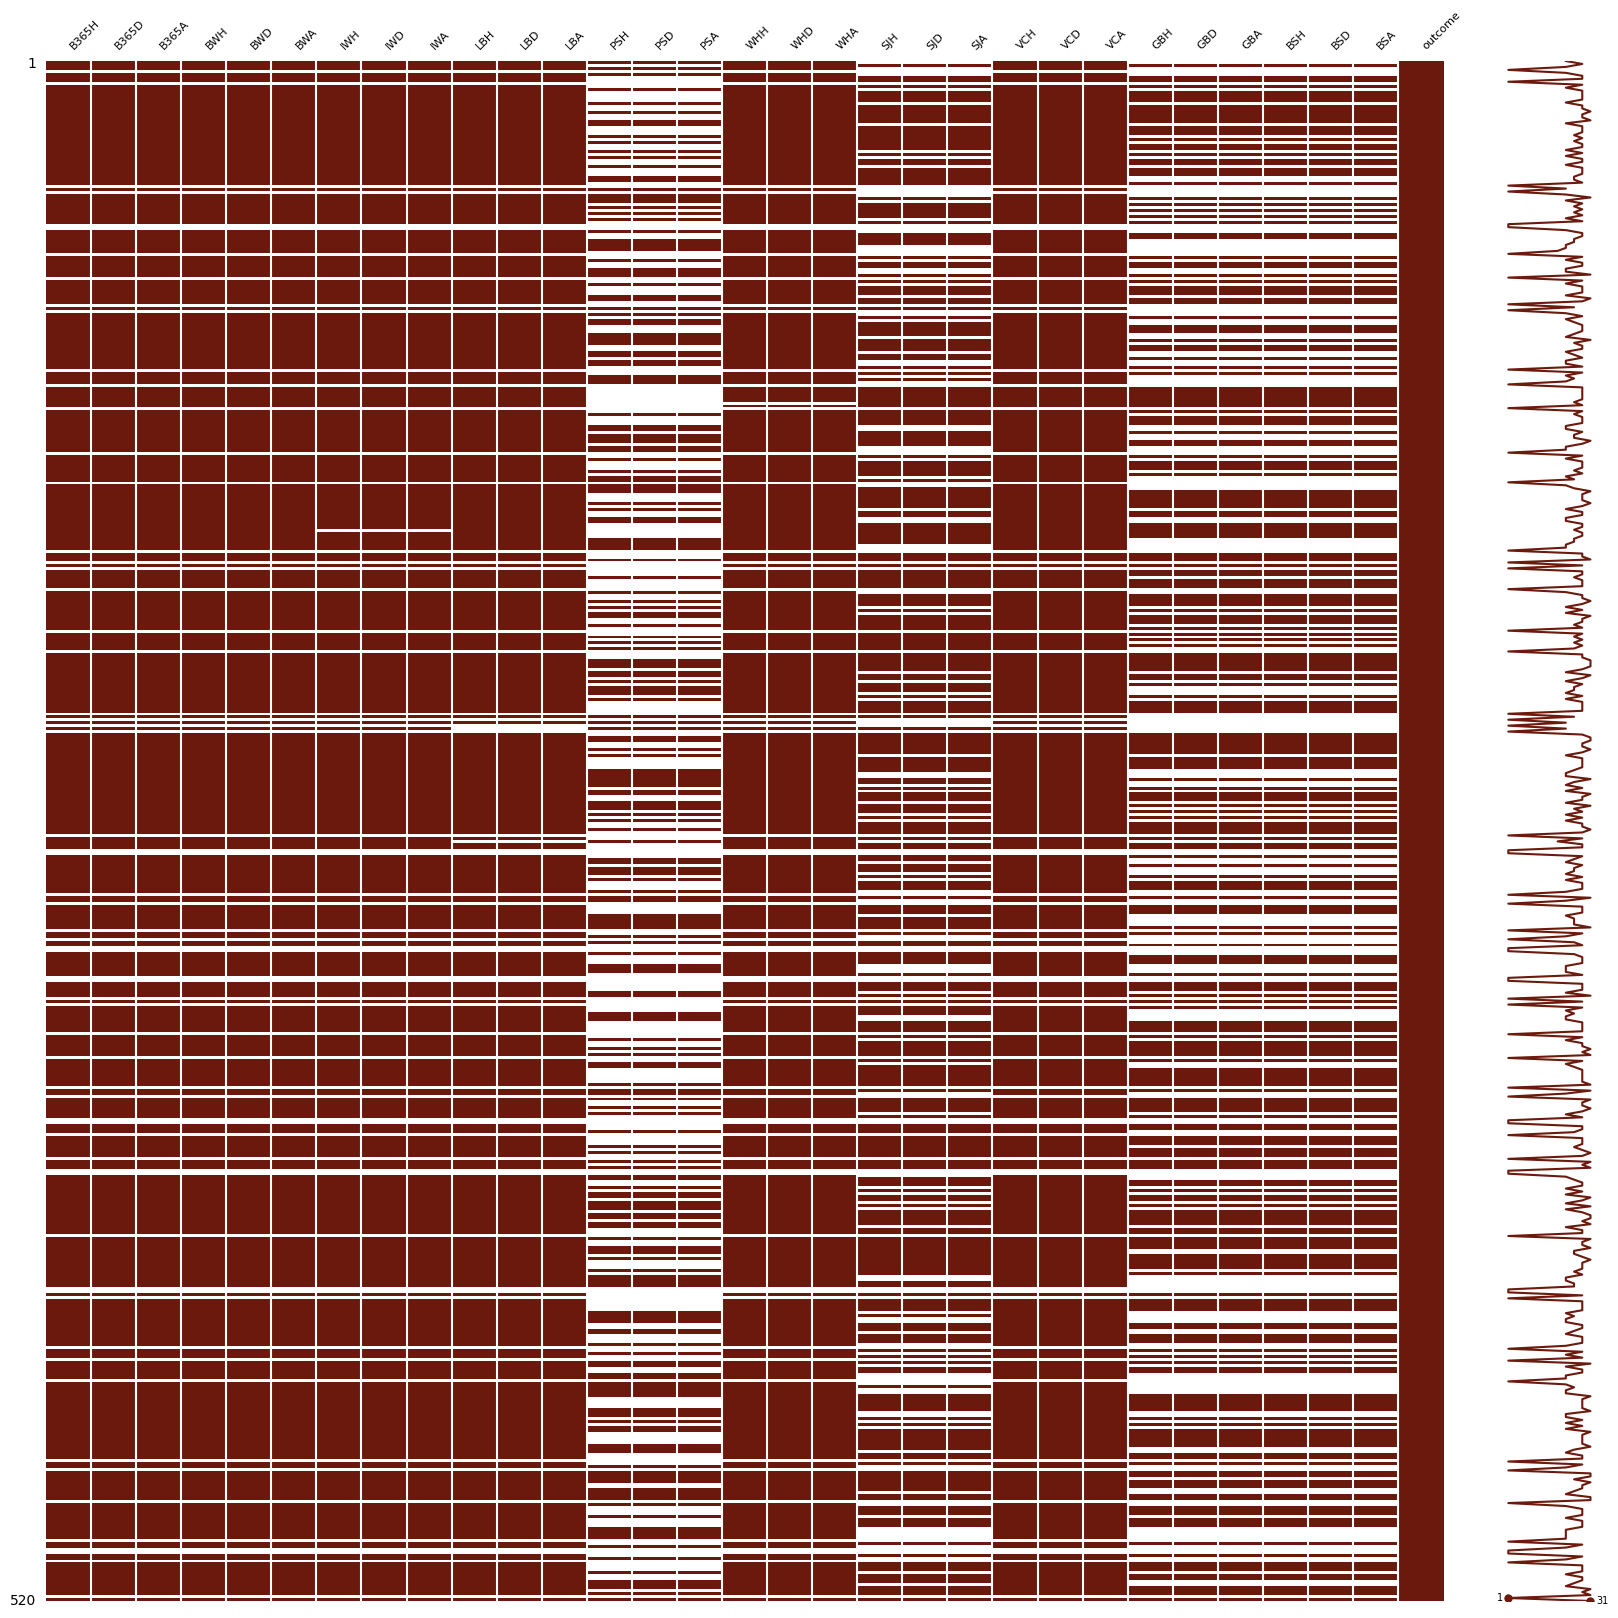

In [1671]:
start = time()
# clean the betting odds dataframe
cln_betting = data_cleaning(mf_betting)
end = time()
print(f'\n The betting odds dataframe cleaning took {round(end - start, 2)} seconds. \n')


The shape of the dataframe is (520, 43) before cleaning. 

The distribution of the missing values in the dataframe is: 
home_team_buildUpPlayDribbling              404
away_team_buildUpPlayDribbling              403
home_team_buildUpPlaySpeed                  112
home_team_chanceCreationShootingClass       112
home_team_buildUpPlaySpeedClass             112
home_team_defenceDefenderLineClass          112
home_team_defenceTeamWidthClass             112
home_team_defenceTeamWidth                  112
home_team_defenceAggressionClass            112
home_team_defencePressureClass              112
home_team_defencePressure                   112
home_team_chanceCreationPositioningClass    112
home_team_defenceAggression                 112
home_team_chanceCreationShooting            112
home_team_chanceCreationCrossing            112
home_team_chanceCreationPassingClass        112
home_team_chanceCreationPassing             112
home_team_buildUpPlayPositioningClass       112
home_team_buildU

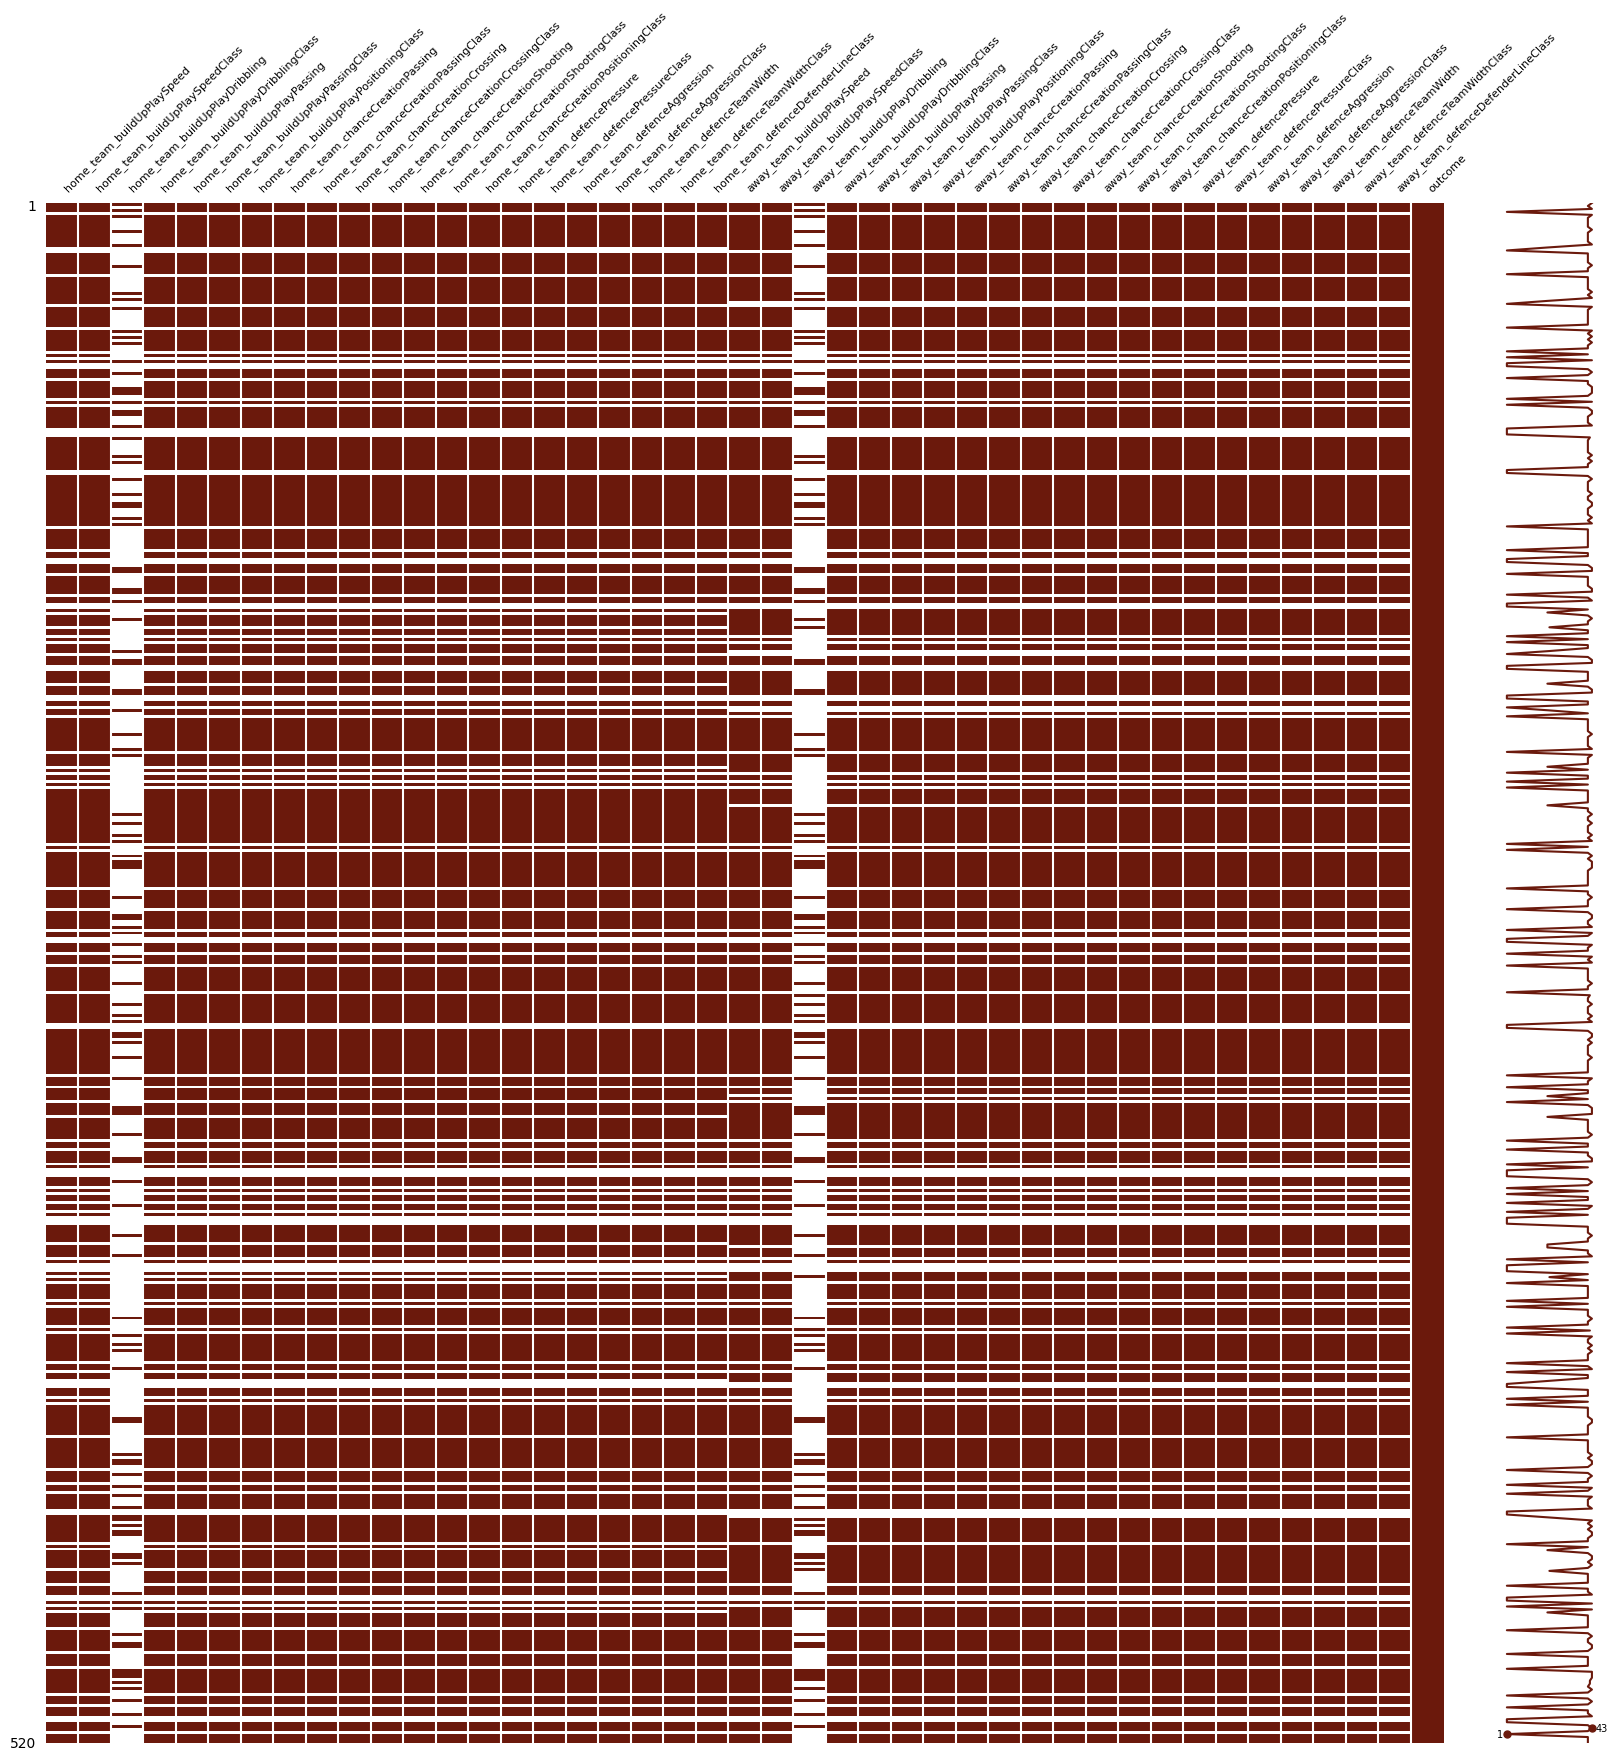

In [1672]:
start = time()
# clean the team attributes dataframe
cln_team = data_cleaning(mf_team)
end = time()
print(f'\n The team attributes dataframe cleaning process took {round(end - start, 2)} seconds. \n')

The shape of the dataframe is (520, 837) before cleaning. 

The distribution of the missing values in the dataframe is: 
away_player_11_attacking_work_rate    37
away_player_11_volleys                33
away_player_11_sliding_tackle         33
home_player_10_attacking_work_rate    33
away_player_11_curve                  33
                                      ..
home_player_7_gk_diving               13
home_player_7_gk_handling             13
home_player_7_gk_kicking              13
home_player_7_gk_reflexes             13
outcome                                0
Length: 837, dtype: int64 

The percentage of missing values in per column and sorted is: 
away_player_11_attacking_work_rate    7.115385
away_player_11_volleys                6.346154
away_player_11_sliding_tackle         6.346154
home_player_10_attacking_work_rate    6.346154
away_player_11_curve                  6.346154
                                        ...   
home_player_7_gk_diving               2.500000
home_pla

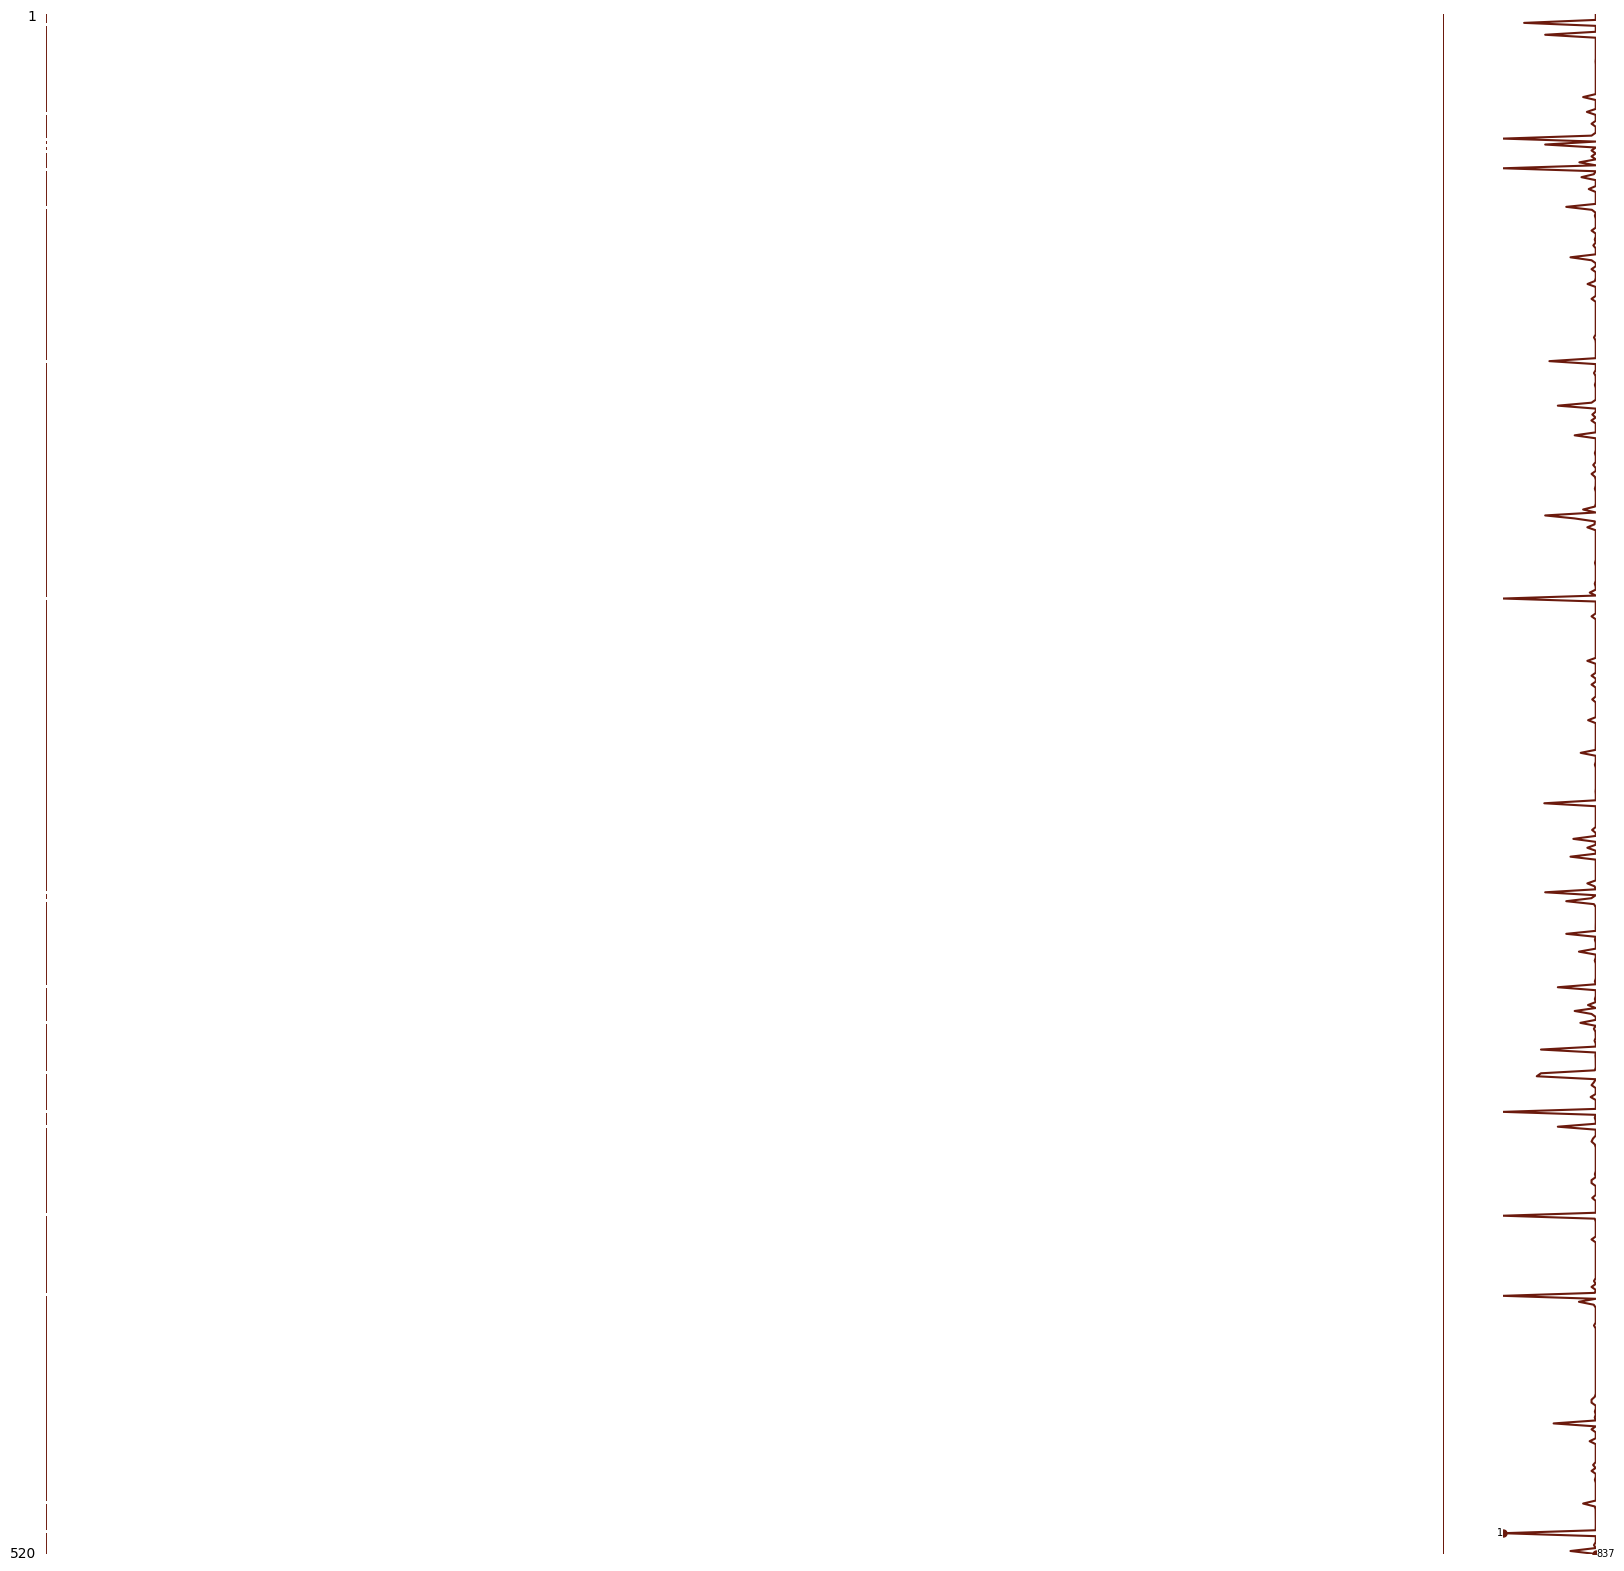

In [1673]:
start = time()
# clean the player attributes dataframe
cln_player = data_cleaning(mf_player)
end = time()
print(f'\n The player attributes dataframe cleaning process took {round(end - start, 2)} seconds. \n')

In [1674]:
# check the shape of the dataframes
cln_betting.shape, cln_player.shape, cln_team.shape

((453, 19), (371, 837), (401, 41))

### Data Transformation

In this section, we will transform the data to make it more suitable for the analysis.
It may include creating new columns, removing outliers, and normalizing the data.

As we are interested in the match outcome, we supposed to create a new column called `outcome` which is the result of the match. The values of this column will be either `home_win`, `away_win`, or `draw`.
But, this column is already created in the previous section, so we will just rename it to `outcome`.

In [1675]:
def data_transformations(df: pd.DataFrame, name : str):
    """
    This function takes a dataframe and returns a dataframe with the transformed features.

    Roadmap
    -------
    1. Get the match outcome.
    2. Drop the match outcome column.
    3. If it is not the betting odds dataframe, transform the floats to int
    4. Check if the skewness is higher than 1 or lower than -1.
    5. If the skewness is higher than 1, bound the outliers by max 75% quantile and  apply the log transformation.
    6. If the skewness is lower than -1, bound the outliers by max 75% quantile, then reflect the values prior to transformation and apply the log transformation.
    7. Return the transformed dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        A dataframe with the odds features.
        
    name : str
        The name of the dataset
    Returns
    -------
    df : pd.DataFrame
        A dataframe with the transformed features.

    """
    df = df.copy()
    # 
    
    print(f'The shape of the dataframe is {df.shape} before transformation. \n')

    # get the match outcome
    outcome = df['outcome']

    # convert the match outcome to integer
    outcome = outcome.astype(int)
    print(f'The match outcome is converted to integer. \n')
    # drop the match outcome column
    df.drop('outcome', axis=1, inplace=True)
    print(f'The match outcome column is dropped. \n')

    if name == 'betting':
        # do noting
        pass
    elif name == 'team' or name == 'player':
        # convert the float columns to integer
        for col in df.select_dtypes(include='float').columns:
            df[col] = df[col].astype(int)
        print(f'The float columns are converted to integer. \n')
    else:
        print(f'Please enter a valid name. \n')

    # check the skewness of the columns
    skewness = df.skew().sort_values(ascending=False)
    print(f'The skewness of the columns is: \n'
        f'{skewness} \n')
    # get the columns with skewness higher than 1 as positive skewed
    pos_skewed = skewness[skewness > 1]
    print(f'The skewness higher than 1 is: \n'
        f'{pos_skewed} \n')
    # get the columns with skewness lower than -1 as negative skewed
    neg_skewed = skewness[skewness < -1]
    print(f'The skewness lower than -1 is: \n'
        f'{neg_skewed} \n')

    if len(pos_skewed) == 0 and len(neg_skewed) == 0:
        print(f'The skewness of the columns is within the range of -1 and 1. \n')
    else:
        print(f'The skewness of the columns is not within the range of -1 and 1. \n')

        if len(pos_skewed) > 0:
            # for outliers in the columns with skewness higher than 1 or lower than -1
            # bound the outliers by max 75% quantile
            for col in pos_skewed.index:
                df[col] = df[col].clip(upper=df[col].quantile(0.75))

            # check current skewness
            pos_skewed = df.skew().sort_values(ascending=False)[df.skew().sort_values(ascending=False) > 1]
            # if the skewness still higher than 1
            if len(pos_skewed) > 0:
                # apply the square root transformation to the positive skewed columns
                df[pos_skewed.index] = np.log(df[pos_skewed.index])
                print(f'The square root transformation is applied to the positive skewed columns. \n')

        if len(neg_skewed) > 0:
            # for outliers in the columns with skewness higher than 1 or lower than -1
            # bound the outliers by max 75% quantile
            for col in neg_skewed.index:
                df[col] = df[col].clip(upper=df[col].quantile(0.75))

            # check current skewness
            neg_skewed = df.skew().sort_values(ascending=False)[df.skew().sort_values(ascending=False) < -1]
            # if the skewness still higher than 1
            if len(neg_skewed) > 0:
                # get the value difference from the max value of the column
                df[neg_skewed.index] = - df[neg_skewed.index]
                df[neg_skewed.index] = np.log(df[neg_skewed.index])
                print(f'The values are reflected prior to transformation. \n')
    
        # check the skewness of the columns
        skewness = df.skew().sort_values(ascending=False)
        print(f'The transformed skewness of the columns is: \n'
            f'{skewness} \n')
        # get the columns with skewness higher than 1 as positive skewed
        pos_skewed = skewness[skewness > 1]
        print(f'The transformed skewness higher than 1 is: \n'
            f'{pos_skewed} \n')
        # get the columns with skewness lower than -1 as negative skewed    
        neg_skewed = skewness[skewness < -1]
        print(f'The transformed skewness lower than -1 is: \n'
            f'{neg_skewed} \n')
                
    print(f'The target variable is added to the dataframe. \n')
    # add the match outcome column
    df['outcome'] = outcome

    print(f'The shape of the dataframe is {df.shape} after transformation. \n')
    return df

In [1676]:
cln_betting.name = relations[0]
start = time()
# transform the data and get the results of the transformation in a dataframe for betting odds dataset
df_betting = data_transformations(cln_betting, cln_betting.name)
end = time()
print(f'The time taken to transform the data is {round(end - start, 2)} seconds. \n')
df_betting.name = cln_betting.name

The shape of the dataframe is (453, 19) before transformation. 

The match outcome is converted to integer. 

The match outcome column is dropped. 

The skewness of the columns is: 
LBA      3.830293
WHH      3.805260
WHA      3.663614
B365H    3.575829
VCH      3.556236
LBH      3.317085
IWH      3.284538
BWH      3.269937
LBD      3.232602
VCD      3.192833
B365D    3.058507
BWA      3.002734
BWD      2.956410
VCA      2.898724
WHD      2.783876
IWD      2.585315
B365A    2.561851
IWA      2.404034
dtype: float64 

The skewness higher than 1 is: 
LBA      3.830293
WHH      3.805260
WHA      3.663614
B365H    3.575829
VCH      3.556236
LBH      3.317085
IWH      3.284538
BWH      3.269937
LBD      3.232602
VCD      3.192833
B365D    3.058507
BWA      3.002734
BWD      2.956410
VCA      2.898724
WHD      2.783876
IWD      2.585315
B365A    2.561851
IWA      2.404034
dtype: float64 

The skewness lower than -1 is: 
Series([], dtype: float64) 

The skewness of the columns is not within t

In [1677]:
cln_team.name = relations[1]
start = time()
# transform the data and get the results of the transformation in a dataframe for team dataset
df_team = data_transformations(cln_team, cln_team.name)
end = time()
print(f'The time taken to transform the data is {round(end - start, 2)} seconds. \n')
df_team.name = cln_team.name


The shape of the dataframe is (401, 41) before transformation. 

The match outcome is converted to integer. 

The match outcome column is dropped. 

The float columns are converted to integer. 

The skewness of the columns is: 
home_team_defencePressure           0.298126
home_team_buildUpPlayPassing        0.265251
away_team_defencePressure           0.229281
home_team_defenceAggression         0.196224
away_team_buildUpPlayPassing        0.126037
away_team_defenceAggression         0.052777
home_team_chanceCreationPassing     0.007317
away_team_chanceCreationShooting   -0.128185
home_team_defenceTeamWidth         -0.132371
home_team_chanceCreationCrossing   -0.137981
away_team_defenceTeamWidth         -0.143002
away_team_chanceCreationCrossing   -0.190969
home_team_chanceCreationShooting   -0.191283
home_team_buildUpPlaySpeed         -0.194869
away_team_chanceCreationPassing    -0.245852
away_team_buildUpPlaySpeed         -0.303392
dtype: float64 

The skewness higher than 1 is: 
Ser

In [1678]:
cln_player.name = relations[2]
start = time()
# transform the data and get the results of the transformation in a dataframe for player dataset
df_player = data_transformations(cln_player, cln_player.name)
end = time()
print(f'The data transformation is completed in {round(end - start, 2)} seconds. \n')
df_player.name = cln_player.name

The shape of the dataframe is (371, 837) before transformation. 

The match outcome is converted to integer. 

The match outcome column is dropped. 

The float columns are converted to integer. 

The skewness of the columns is: 
home_player_10_gk_kicking        3.193423
away_player_1_interceptions      3.139711
home_player_1_interceptions      3.056200
home_player_11_gk_kicking        3.026314
home_player_5_gk_kicking         3.006329
                                   ...   
away_player_2_sliding_tackle    -1.515789
home_player_5_marking           -1.646000
home_player_3_marking           -1.791294
home_player_5_standing_tackle   -1.828107
home_player_5_sliding_tackle    -1.857823
Length: 770, dtype: float64 

The skewness higher than 1 is: 
home_player_10_gk_kicking       3.193423
away_player_1_interceptions     3.139711
home_player_1_interceptions     3.056200
home_player_11_gk_kicking       3.026314
home_player_5_gk_kicking        3.006329
                                  ...   
h

## Data Analysis

### Descriptive Statistics

In [1679]:
def descriptive_statistics(df: pd.DataFrame):
    """
    Get the descriptive statistics of the dataframe.
    
    Roadmap
    -------
    1. Get the most common match outcome.
    2. Get the descriptive statistics of the features.
    3. Get the correlation of the features.
    4. Get the correlation of the features with the match outcome.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to get the descriptive statistics.

    Returns
    -------
    result : list
        The dataframe with the descriptive statistics.
    """

    result = {}

    shape = df.shape
    print(f'The shape of the dataframe is {shape}. \n')
    result['shape'] = shape

    # get the most common match outcome
    cmc_outcome = df['outcome'].value_counts()
    print(f'The most common match outcome is: \n'
        f'{cmc_outcome} \n')
    result['cmc_outcome'] = cmc_outcome

    # higest and lowest match outcome percentage
    hig_outcome = df['outcome'].value_counts().idxmax() / df.shape[0]
    low_outcome = df['outcome'].value_counts().idxmin() / df.shape[0]
    print(f'The highest match outcome is: \n'
        f'{hig_outcome} \n')
    print(f'The lowest match outcome is: \n'
        f'{low_outcome} \n')
    result['hig_outcome'] = hig_outcome
    result['low_outcome'] = low_outcome

    # get the descriptive statistics of the features
    desc_stat = df.describe()
    print(f'The descriptive statistics of the features is: \n'
        f'{desc_stat} \n')
    result['desc_stat'] = desc_stat

    # get the correlation of the features
    corr = df.corr()
    print(f'The correlation of the features is: \n'
        f'{corr} \n')
    result['corr'] = corr

    # get the correlation of the features with the match outcome
    corr_outcome = df.corr()['outcome'].sort_values(ascending=False)
    print(f'The correlation of the features with the match outcome is: \n'
        f'{corr_outcome} \n')
    result['corr_outcome'] = corr_outcome

    # get the highest correlation of the features with the match outcome ( higher than 0.1 or lower than -0.1)
    high_corr_outcome = corr_outcome[(corr_outcome > 0.1) | (corr_outcome < -0.1)]
    # drop he match outcome itself
    high_corr_outcome = high_corr_outcome.drop('outcome')
    print(f'The highest correlation of the features with the match outcome is: \n'
        f'{high_corr_outcome} \n')
    result['high_corr_outcome'] = high_corr_outcome

    low_corr_outcome = corr_outcome[(corr_outcome < 0.1) & (corr_outcome > -0.1)]
    print(f'The lowest correlation of the features with the match outcome is: \n'
        f'{low_corr_outcome} \n')
    result['low_corr_outcome'] = low_corr_outcome

    return result


In [1680]:
start = time()
# get the descriptive statistics of the betting odds dataset
desc_betting = descriptive_statistics(df_betting)
end = time()
print(f'The descriptive statistics of the betting odds dataset is done in {round(end - start, 2)} seconds. \n')

The shape of the dataframe is (453, 19). 

The most common match outcome is: 
 1    201
-1    140
 0    112
Name: outcome, dtype: int64 

The highest match outcome is: 
0.002207505518763797 

The lowest match outcome is: 
0.0 

The descriptive statistics of the features is: 
            B365H       B365D       B365A         BWH         BWD         BWA  \
count  453.000000  453.000000  453.000000  453.000000  453.000000  453.000000   
mean     2.213598    3.485166    3.348764    2.182494    3.425828    3.243179   
std      0.559905    0.306420    1.120413    0.542728    0.286950    1.047915   
min      1.080000    2.150000    1.100000    1.090000    2.150000    1.100000   
25%      1.800000    3.250000    2.400000    1.750000    3.250000    2.400000   
50%      2.200000    3.400000    3.400000    2.150000    3.300000    3.300000   
75%      2.900000    3.900000    4.750000    2.850000    3.800000    4.500000   
max      2.900000    3.900000    4.750000    2.850000    3.800000    4.50000

In [1681]:
start = time()
# get the descriptive statistics of the team dataset
desc_team = descriptive_statistics(df_team)
end = time()
print(f'The descriptive statistics of the team dataset is done in {round(end - start, 2)} seconds. \n')

The shape of the dataframe is (401, 41). 

The most common match outcome is: 
 1    179
-1    119
 0    103
Name: outcome, dtype: int64 

The highest match outcome is: 
0.0024937655860349127 

The lowest match outcome is: 
0.0 

The descriptive statistics of the features is: 
       home_team_buildUpPlaySpeed  home_team_buildUpPlayPassing  \
count                  401.000000                    401.000000   
mean                    52.167082                     47.962594   
std                     11.786624                     11.216555   
min                     24.000000                     23.000000   
25%                     45.000000                     39.000000   
50%                     52.000000                     49.000000   
75%                     62.000000                     55.000000   
max                     77.000000                     80.000000   

       home_team_chanceCreationPassing  home_team_chanceCreationCrossing  \
count                       401.000000     

In [1682]:
start = time()
# get the descriptive statistics of the player dataset
desc_player = descriptive_statistics(df_player)
end = time()
print(f'The descriptive statistics of the betting odds is done in {round(end - start, 2)} seconds. \n')

The shape of the dataframe is (371, 837). 

The most common match outcome is: 
 1    165
-1    110
 0     96
Name: outcome, dtype: int64 

The highest match outcome is: 
0.0026954177897574125 

The lowest match outcome is: 
0.0 

The descriptive statistics of the features is: 
       home_player_1_overall_rating  home_player_1_potential  \
count                    371.000000               371.000000   
mean                      73.530997                76.522911   
std                        6.626807                 6.510813   
min                       51.000000                59.000000   
25%                       69.000000                72.000000   
50%                       74.000000                77.000000   
75%                       78.000000                81.500000   
max                       90.000000                91.000000   

       home_player_1_crossing  home_player_1_finishing  \
count              371.000000               371.000000   
mean                17.770889

### Data Visualization

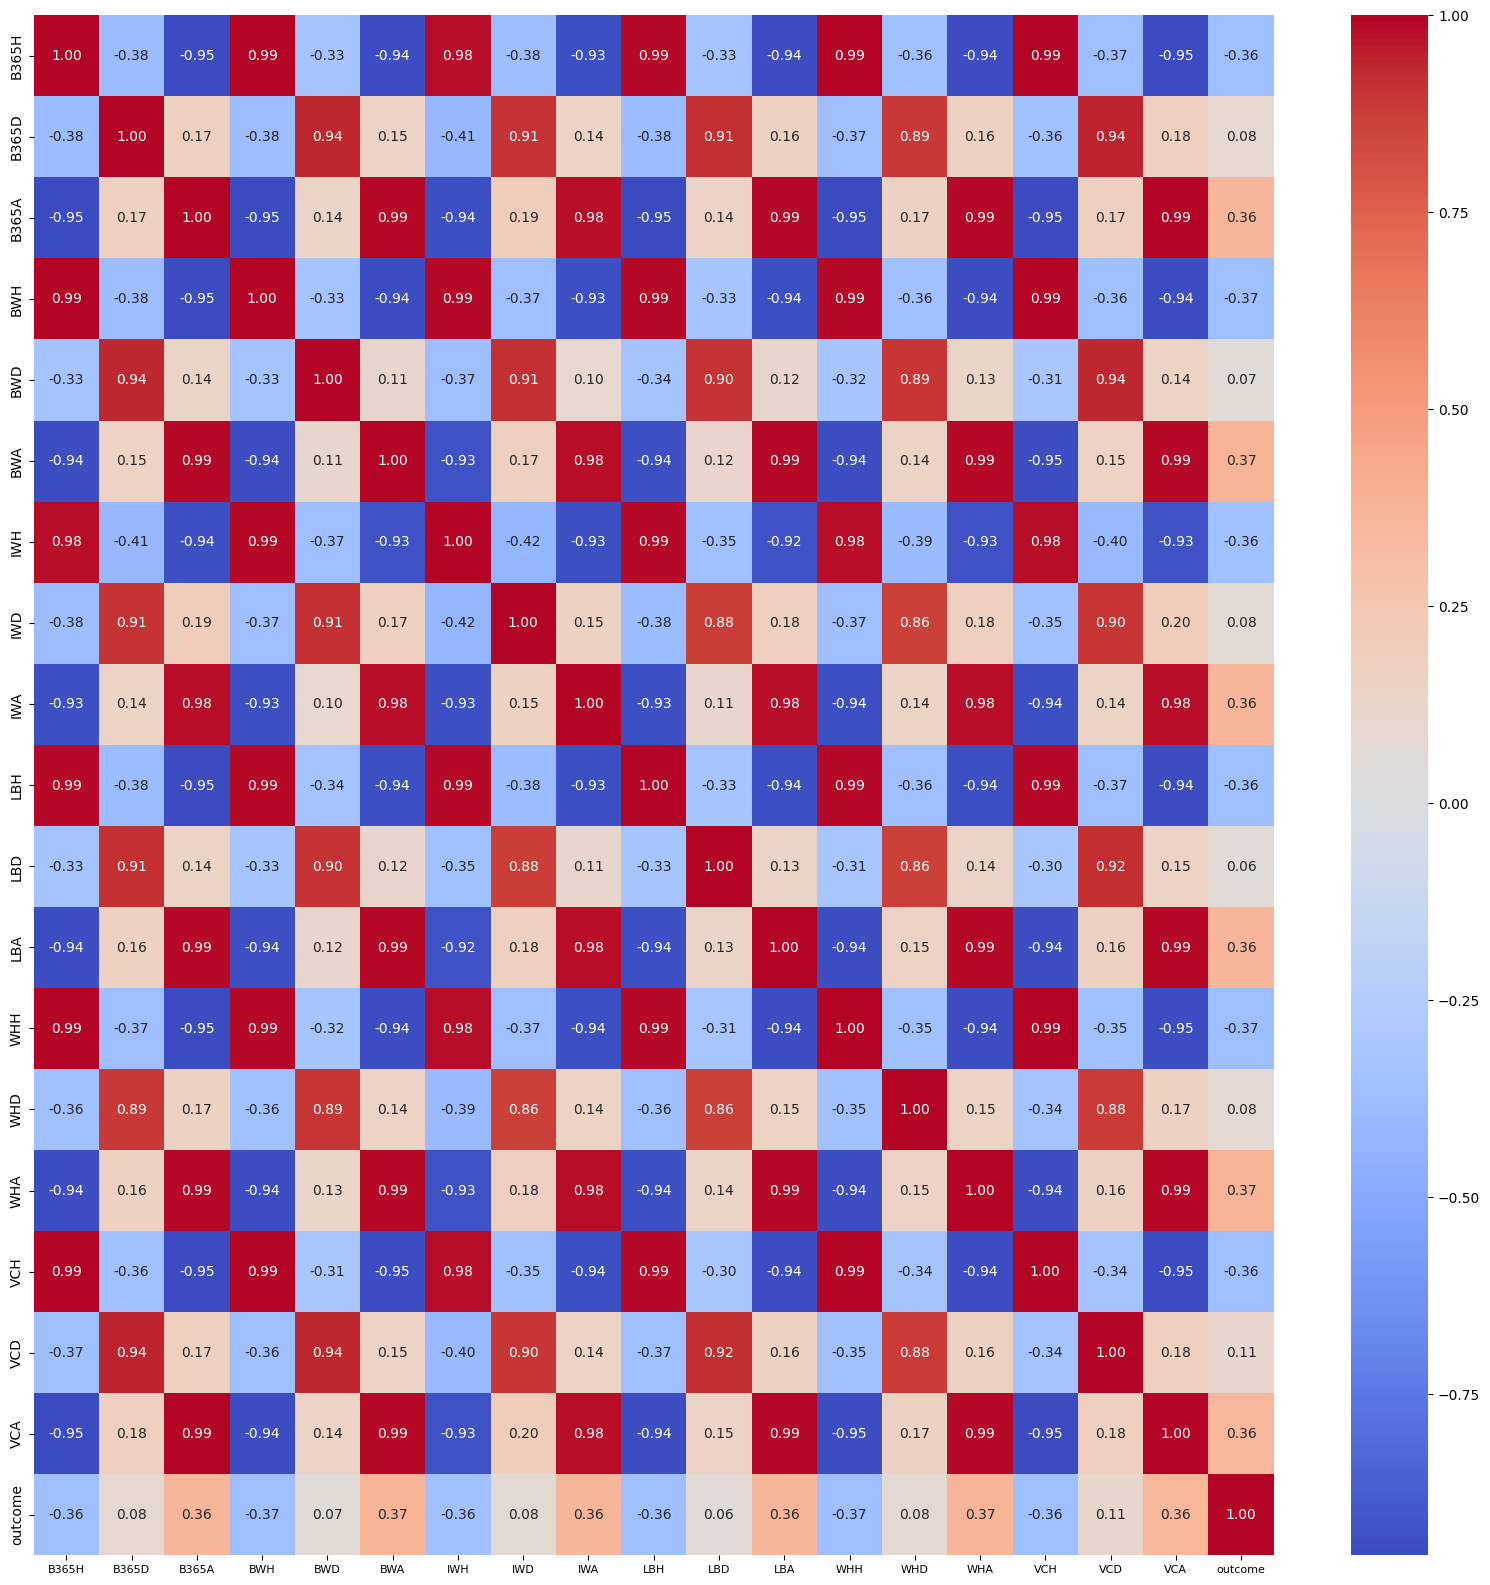

In [1683]:
# plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(desc_betting['corr'], annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

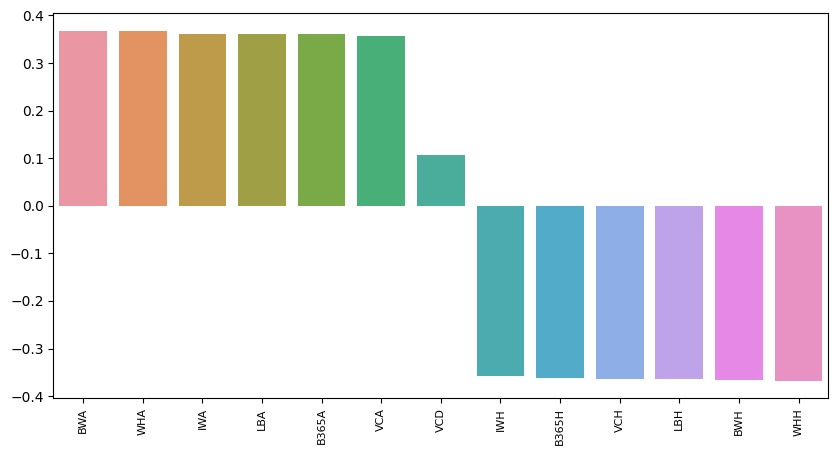

In [1684]:
# plot the highest correlations of the betting odds dataframe with the outcome column
plt.figure(figsize=(10, 5))
sns.barplot(x=desc_betting['high_corr_outcome'].index, y=desc_betting['high_corr_outcome'].values)
plt.xticks(rotation=90)
plt.show()

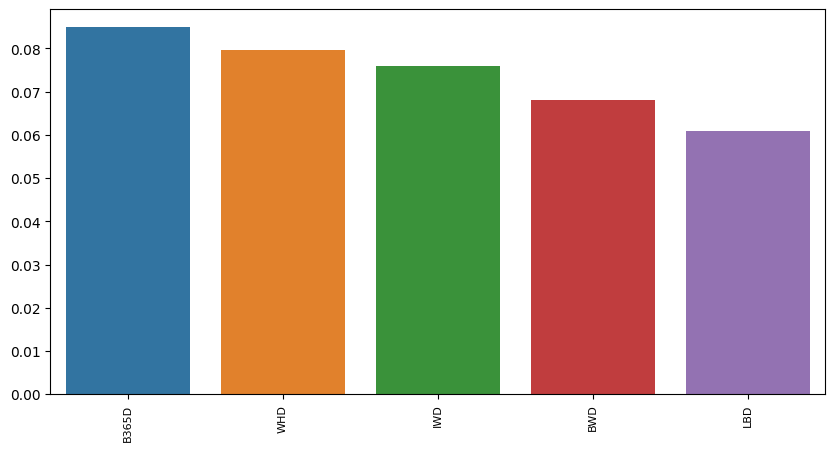

In [1685]:
# plot the least correlations of the betting odds dataframe with the outcome column
plt.figure(figsize=(10, 5))
sns.barplot(x=desc_betting['low_corr_outcome'].index, y=desc_betting['low_corr_outcome'].values)
plt.xticks(rotation=90)
plt.show()

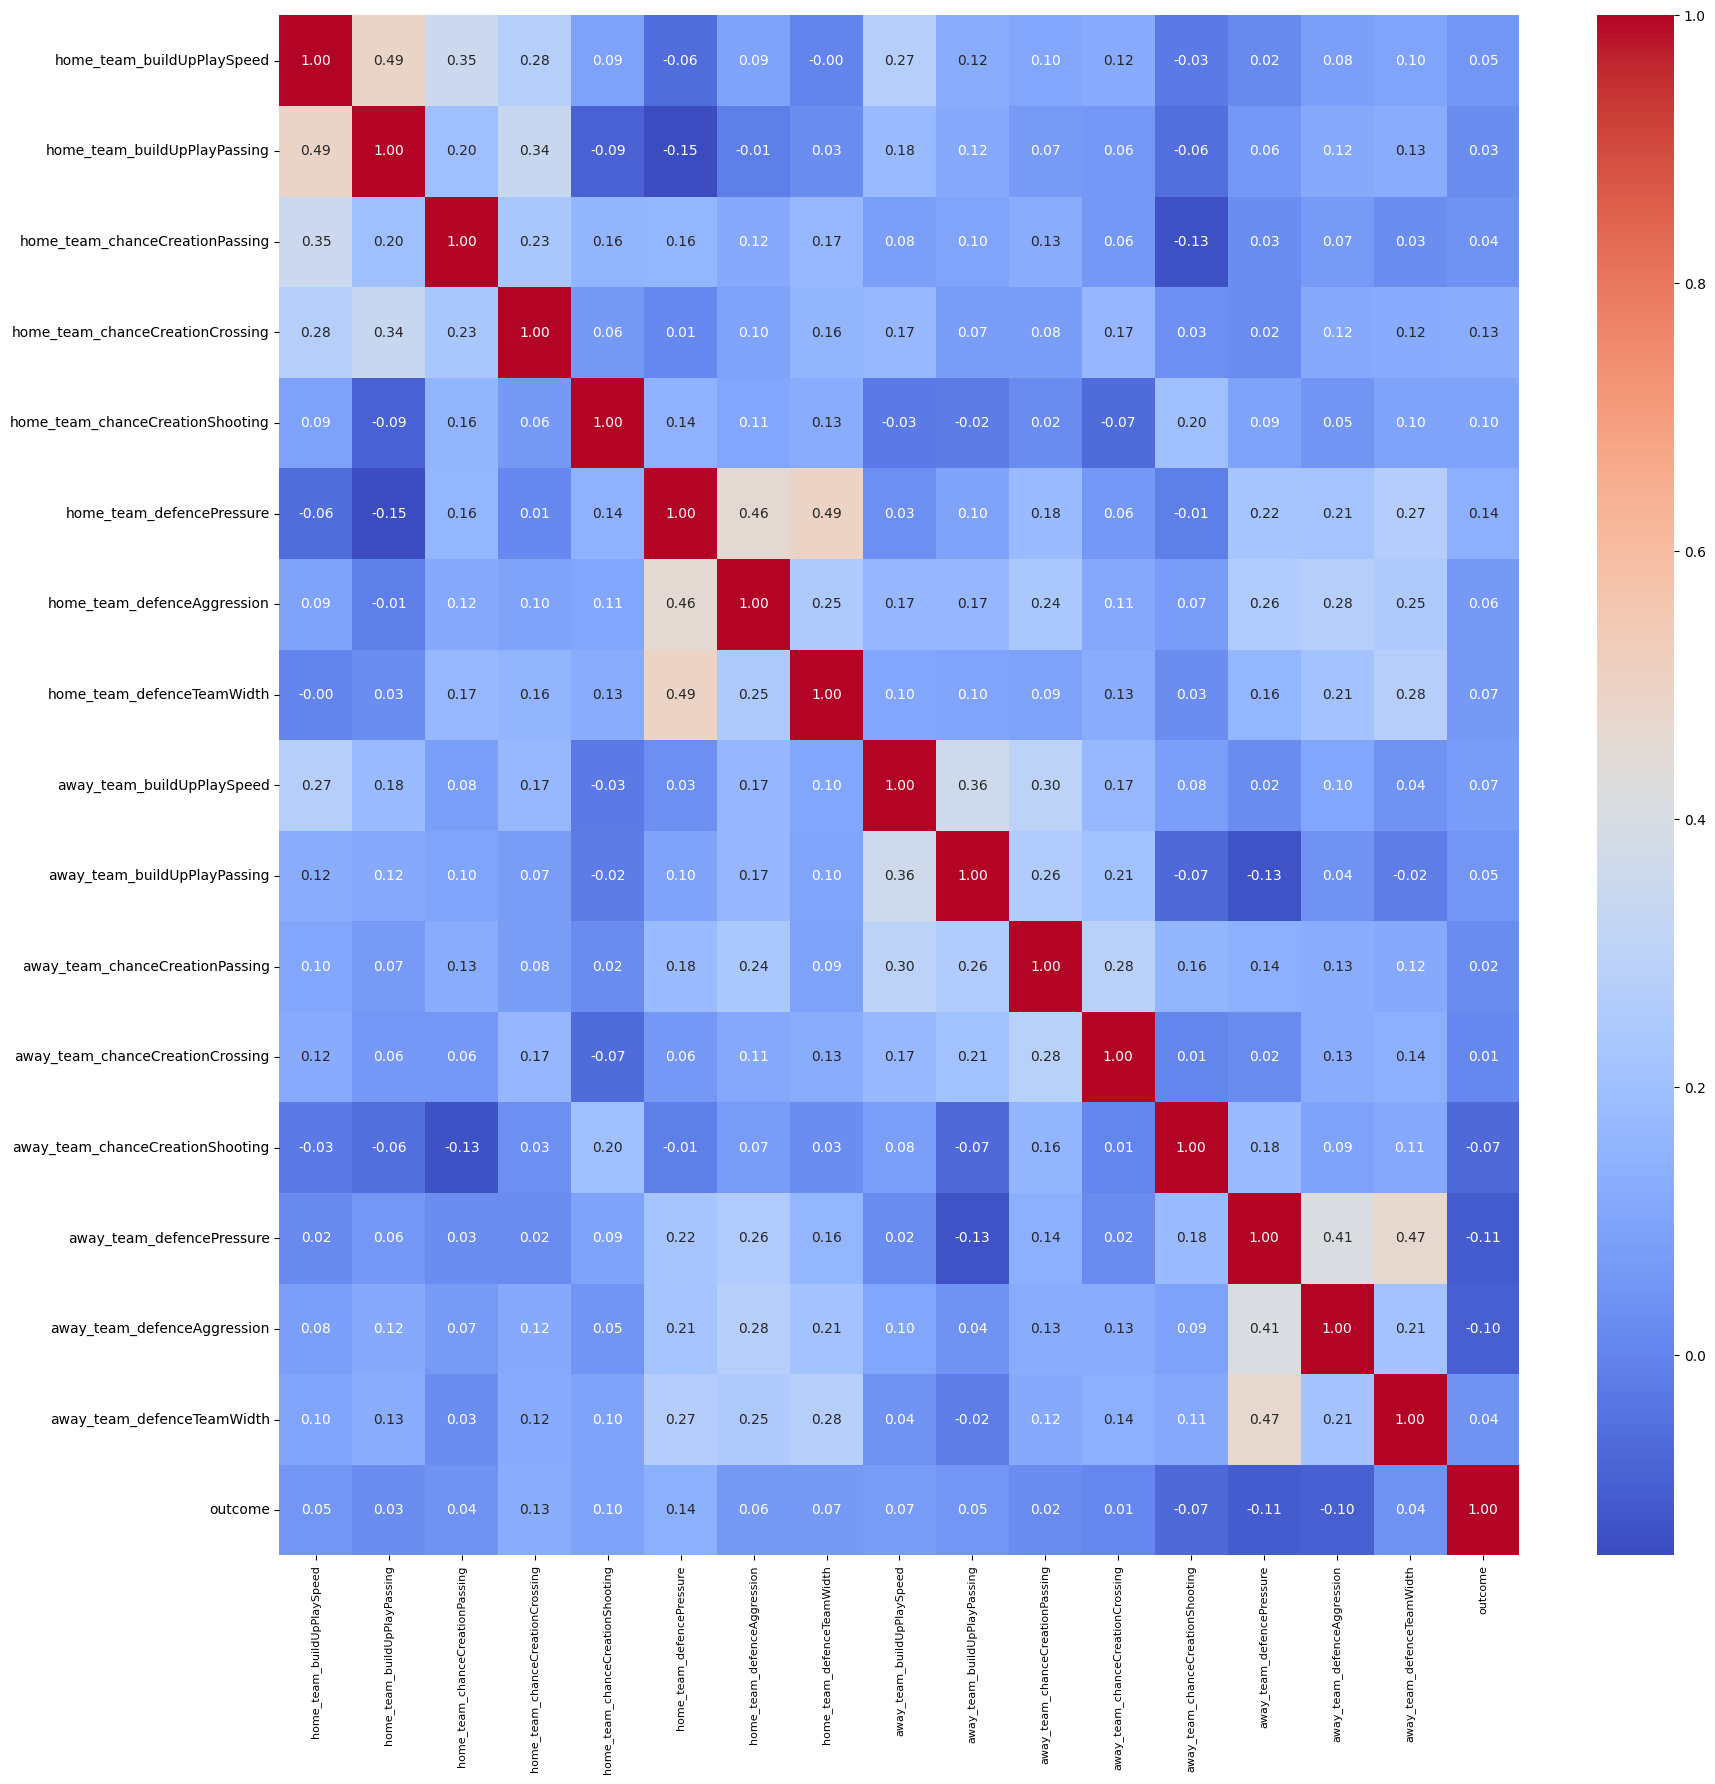

In [1686]:
# plot the correlations of the team attributes dataframe
plt.figure(figsize=(20, 20))
sns.heatmap(desc_team['corr'], annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

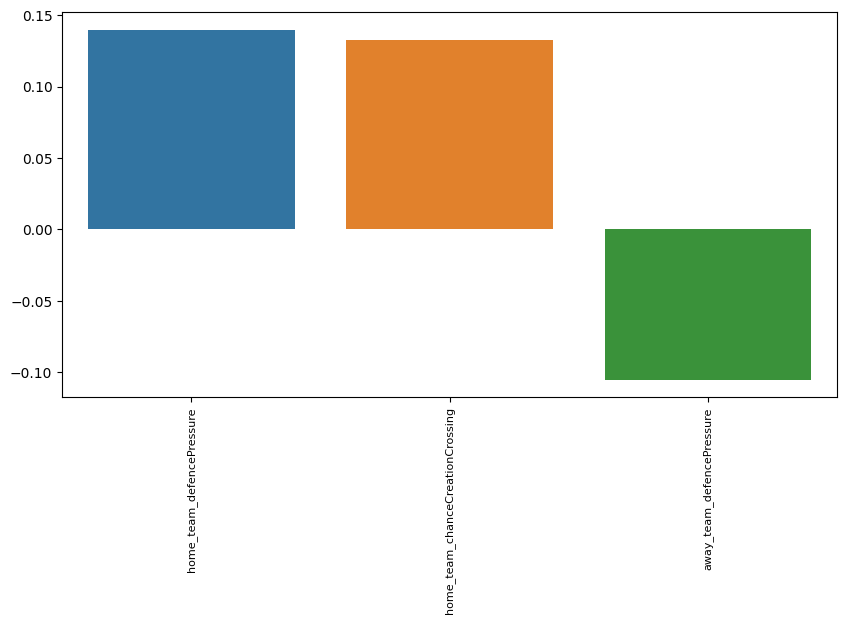

In [1687]:
# plot the highest correlations of the team attributes dataframe with the outcome column
plt.figure(figsize=(10, 5))
sns.barplot(x=desc_team['high_corr_outcome'].index, y=desc_team['high_corr_outcome'].values)
plt.xticks(rotation=90)
plt.show()

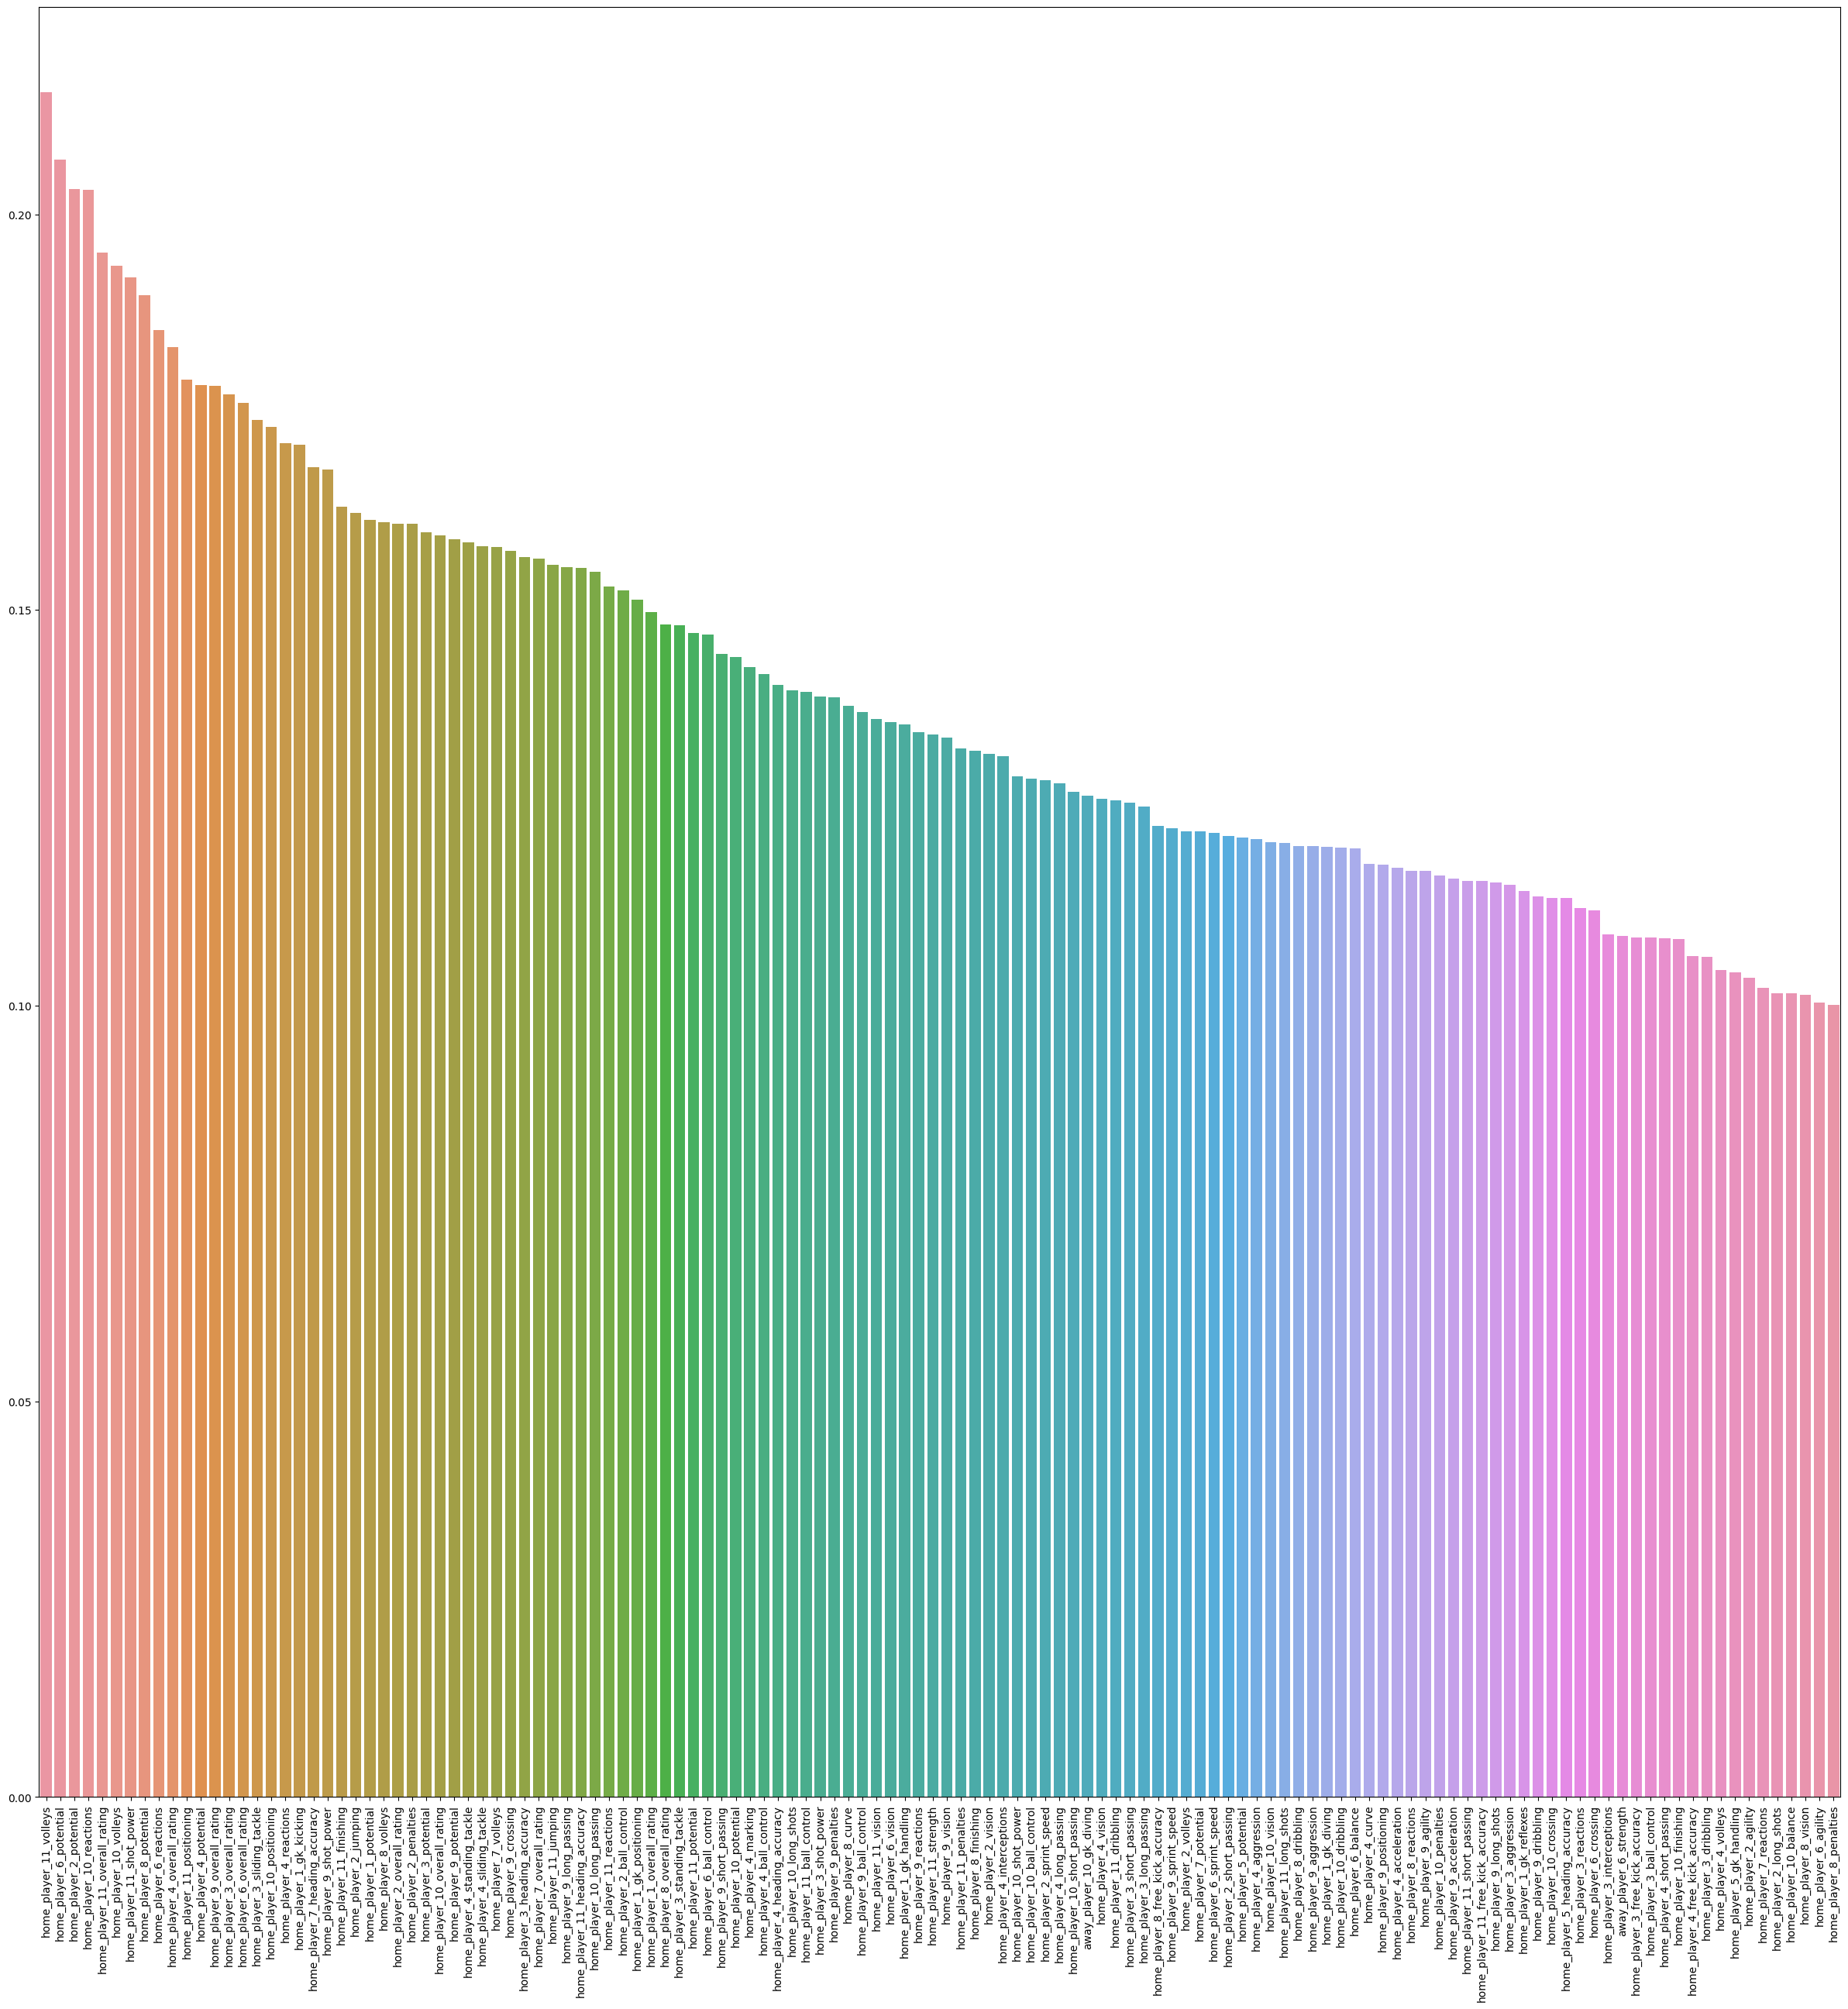

In [1688]:
# plot the highest correlations of the player attributes dataframe with the outcome column where the values are positive
# decrease the label size
plt.rc('xtick', labelsize=10)
plt.figure(figsize=(30, 30))
sns.barplot(x=desc_player['high_corr_outcome'][desc_player['high_corr_outcome'] > 0].index, y=desc_player['high_corr_outcome'][desc_player['high_corr_outcome'] > 0].values)
plt.xticks(rotation=90)
plt.show()

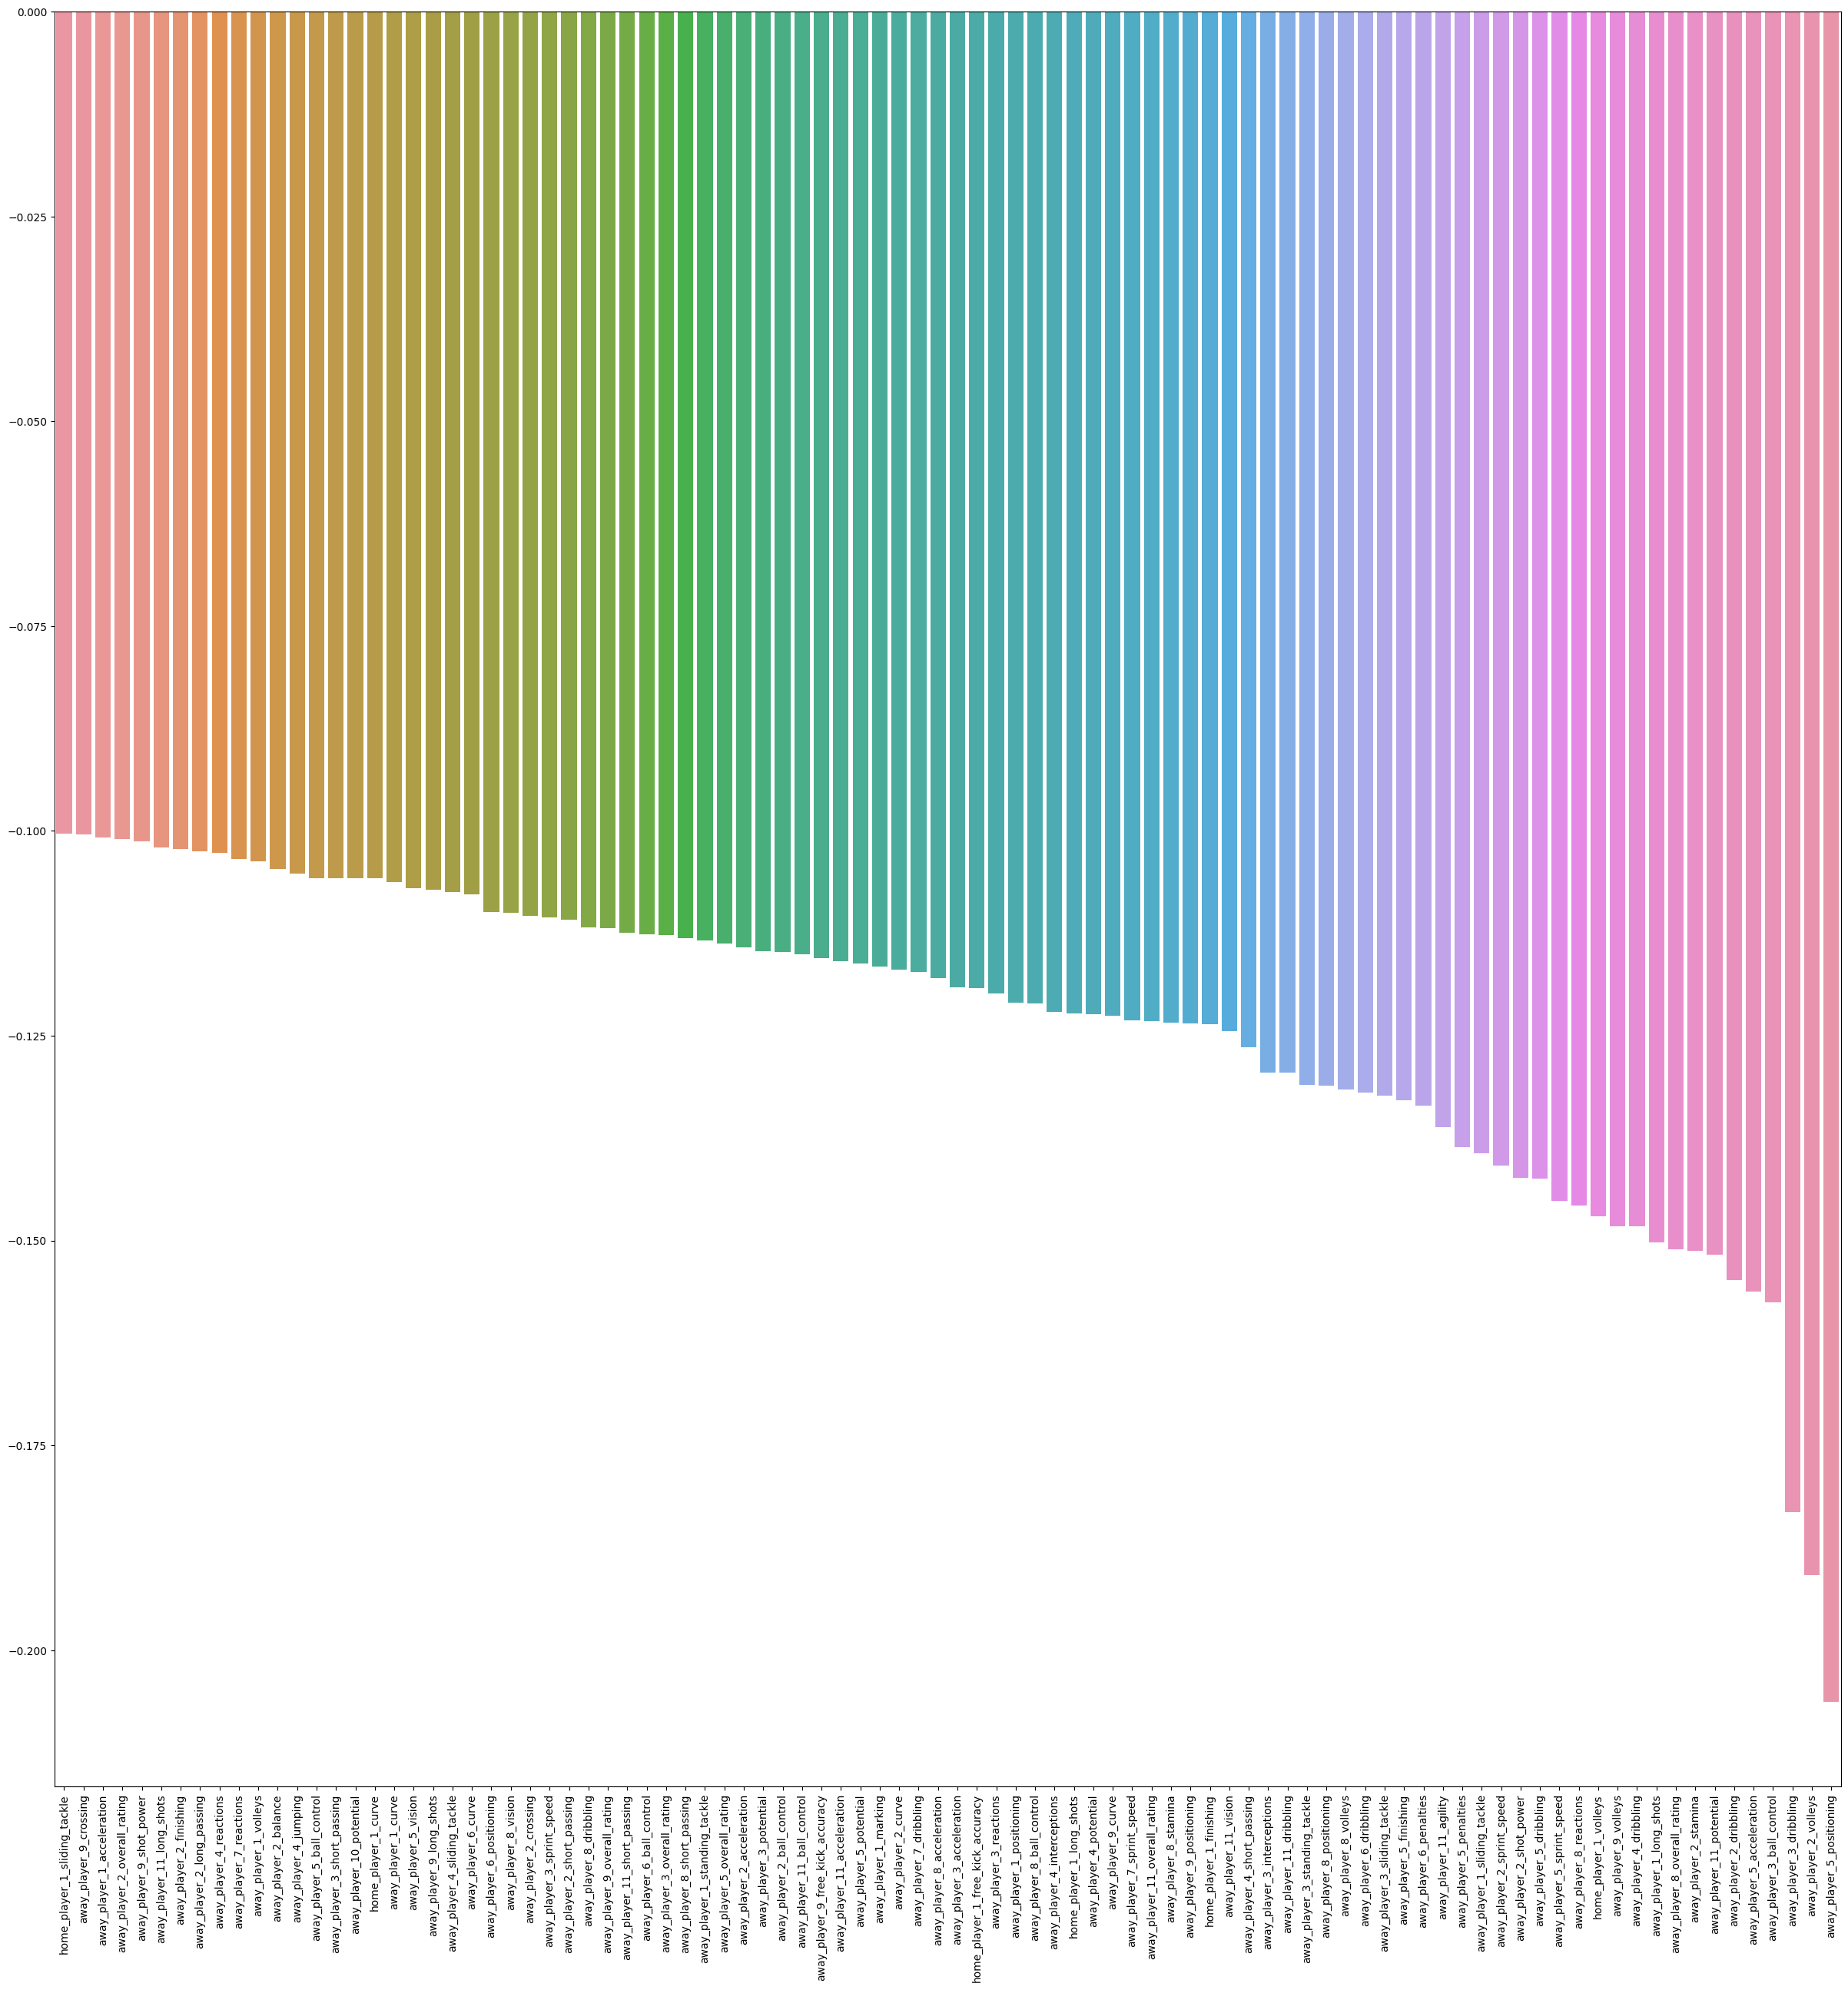

In [1689]:
# plot the highest correlations of the player attributes dataframe with the outcome column where the values are negative
# decrease the label size
plt.rc('xtick', labelsize=10)
plt.figure(figsize=(30, 30))
sns.barplot(x=desc_player['high_corr_outcome'][desc_player['high_corr_outcome'] < 0].index, y=desc_player['high_corr_outcome'][desc_player['high_corr_outcome'] < 0].values)
plt.xticks(rotation=90)
plt.show()

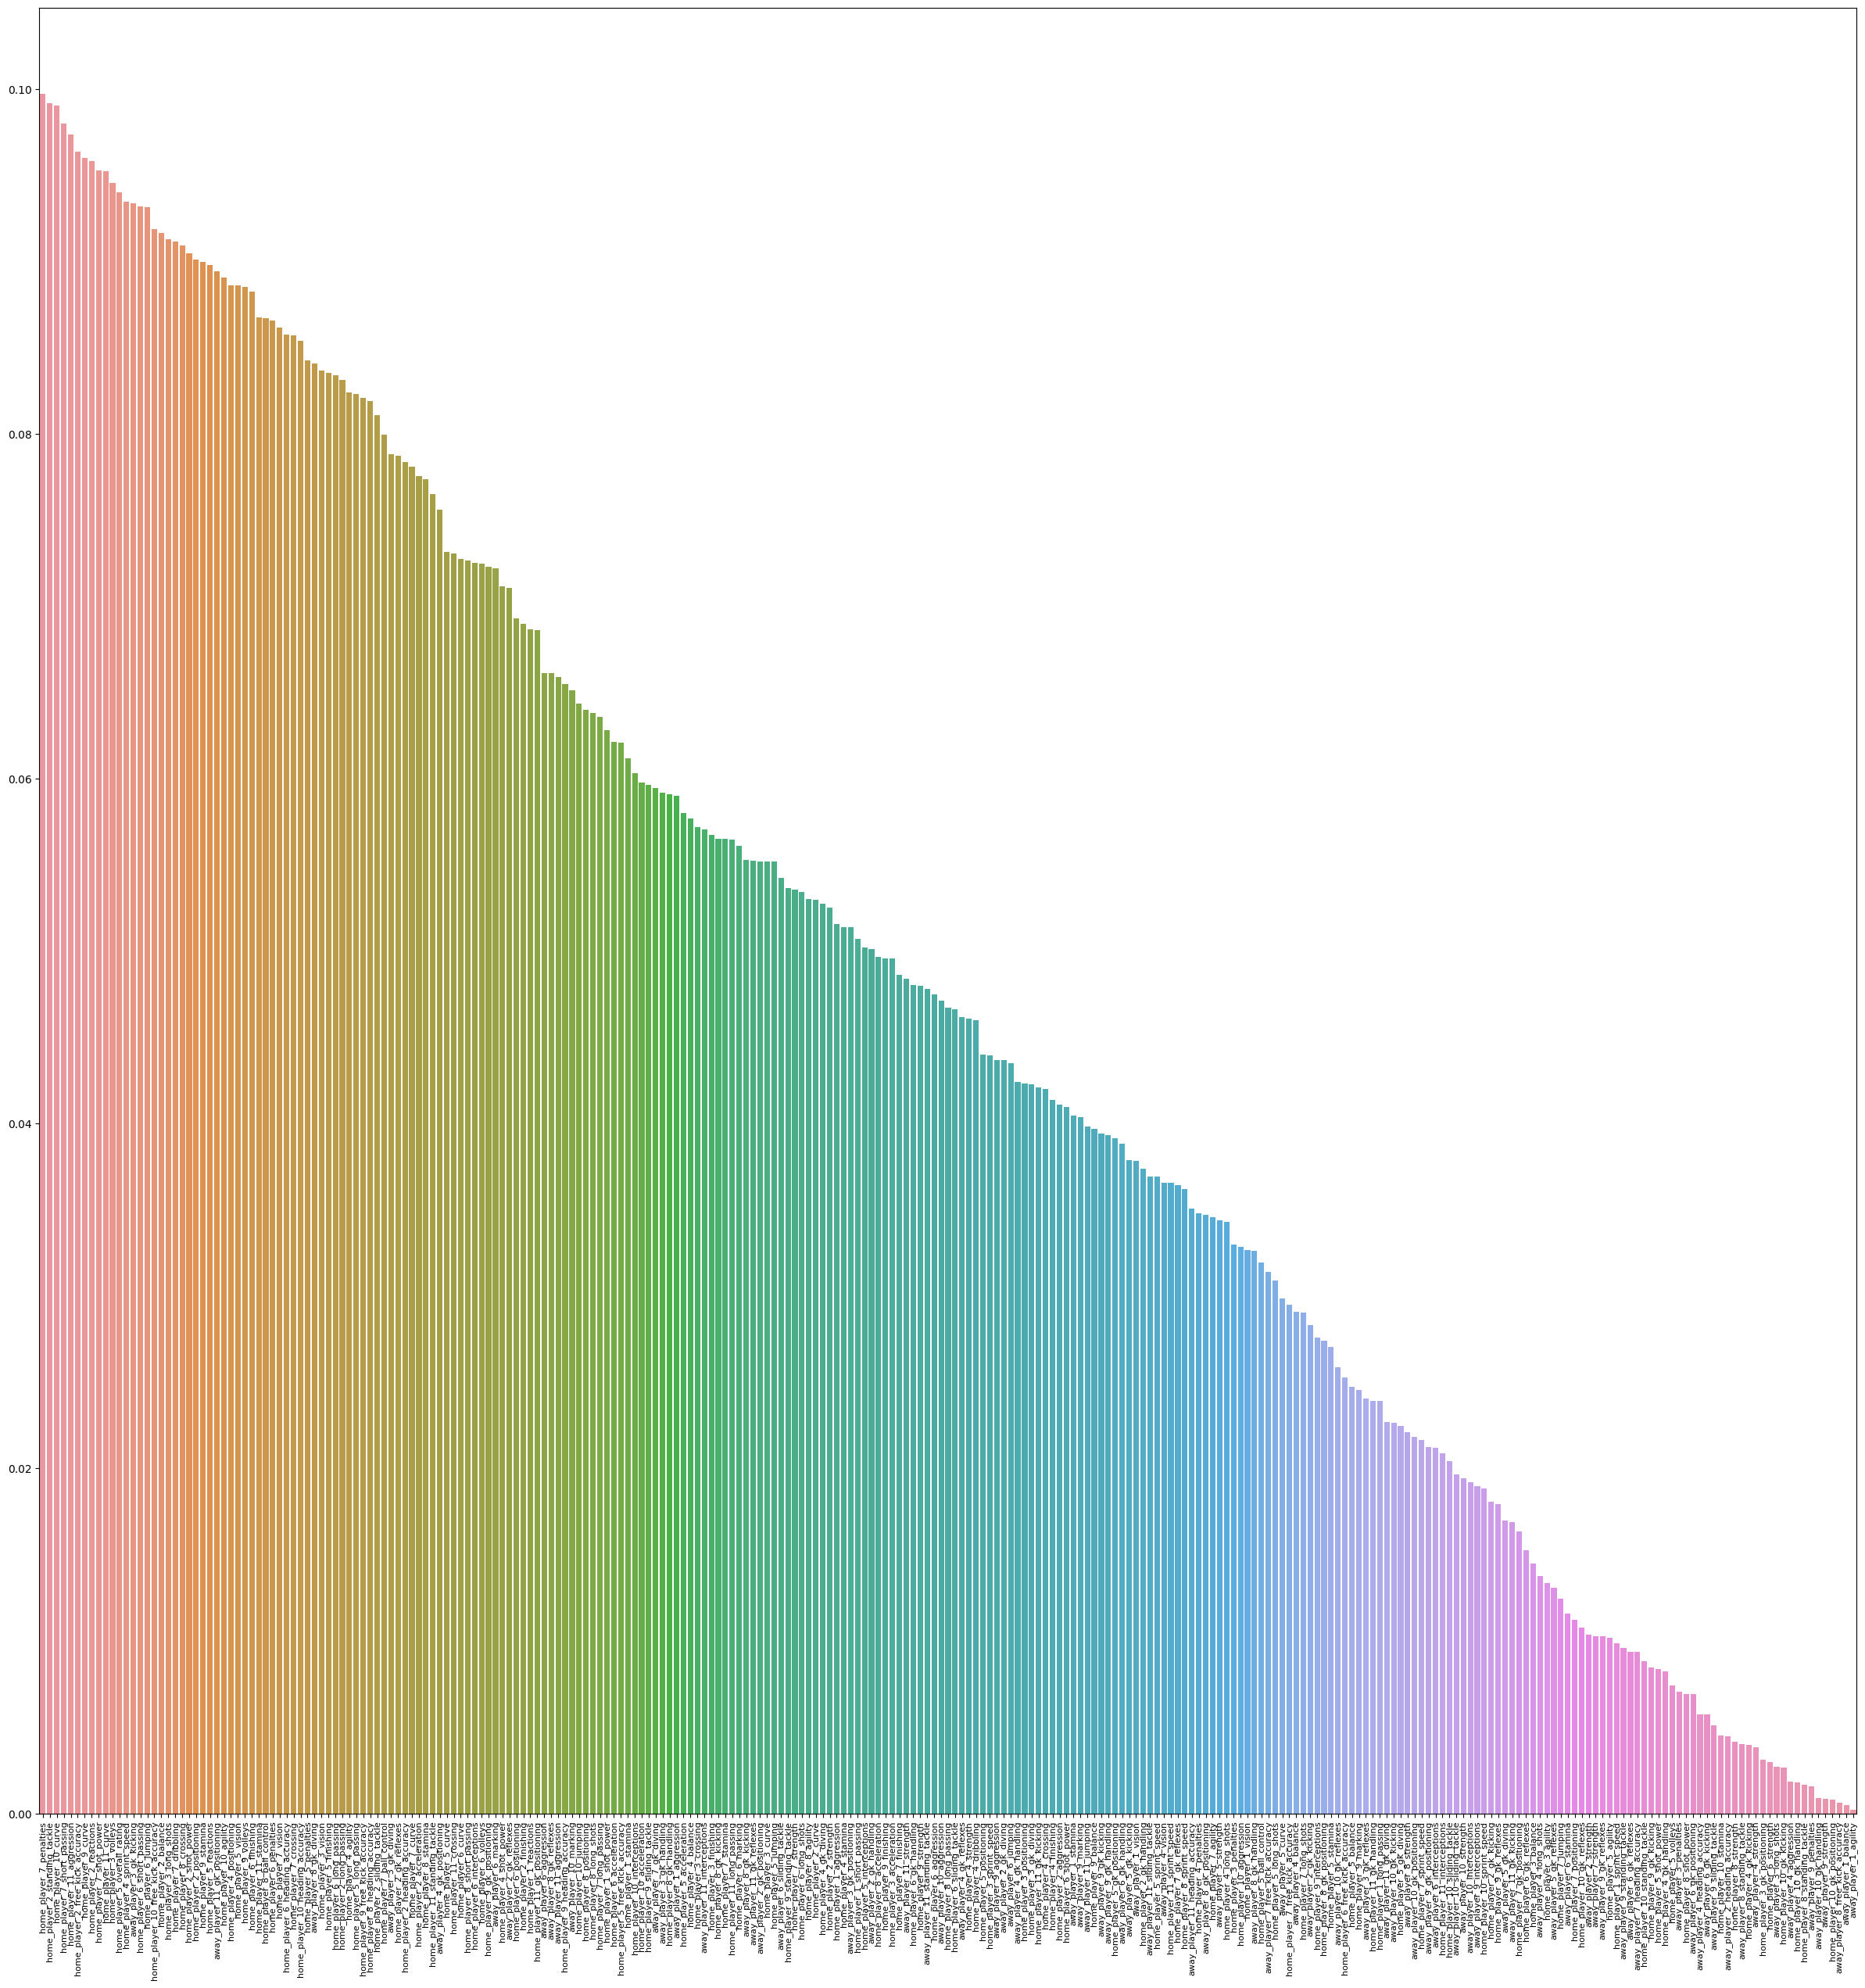

In [1690]:
# draw graph of the least important features with the outcome column for positive values
plt.rc('xtick', labelsize=8)
plt.figure(figsize=(30, 30))
sns.barplot(x=desc_player['low_corr_outcome'][desc_player['low_corr_outcome'] > 0].index, y=desc_player['low_corr_outcome'][desc_player['low_corr_outcome'] > 0].values)
plt.xticks(rotation=90)
plt.show()

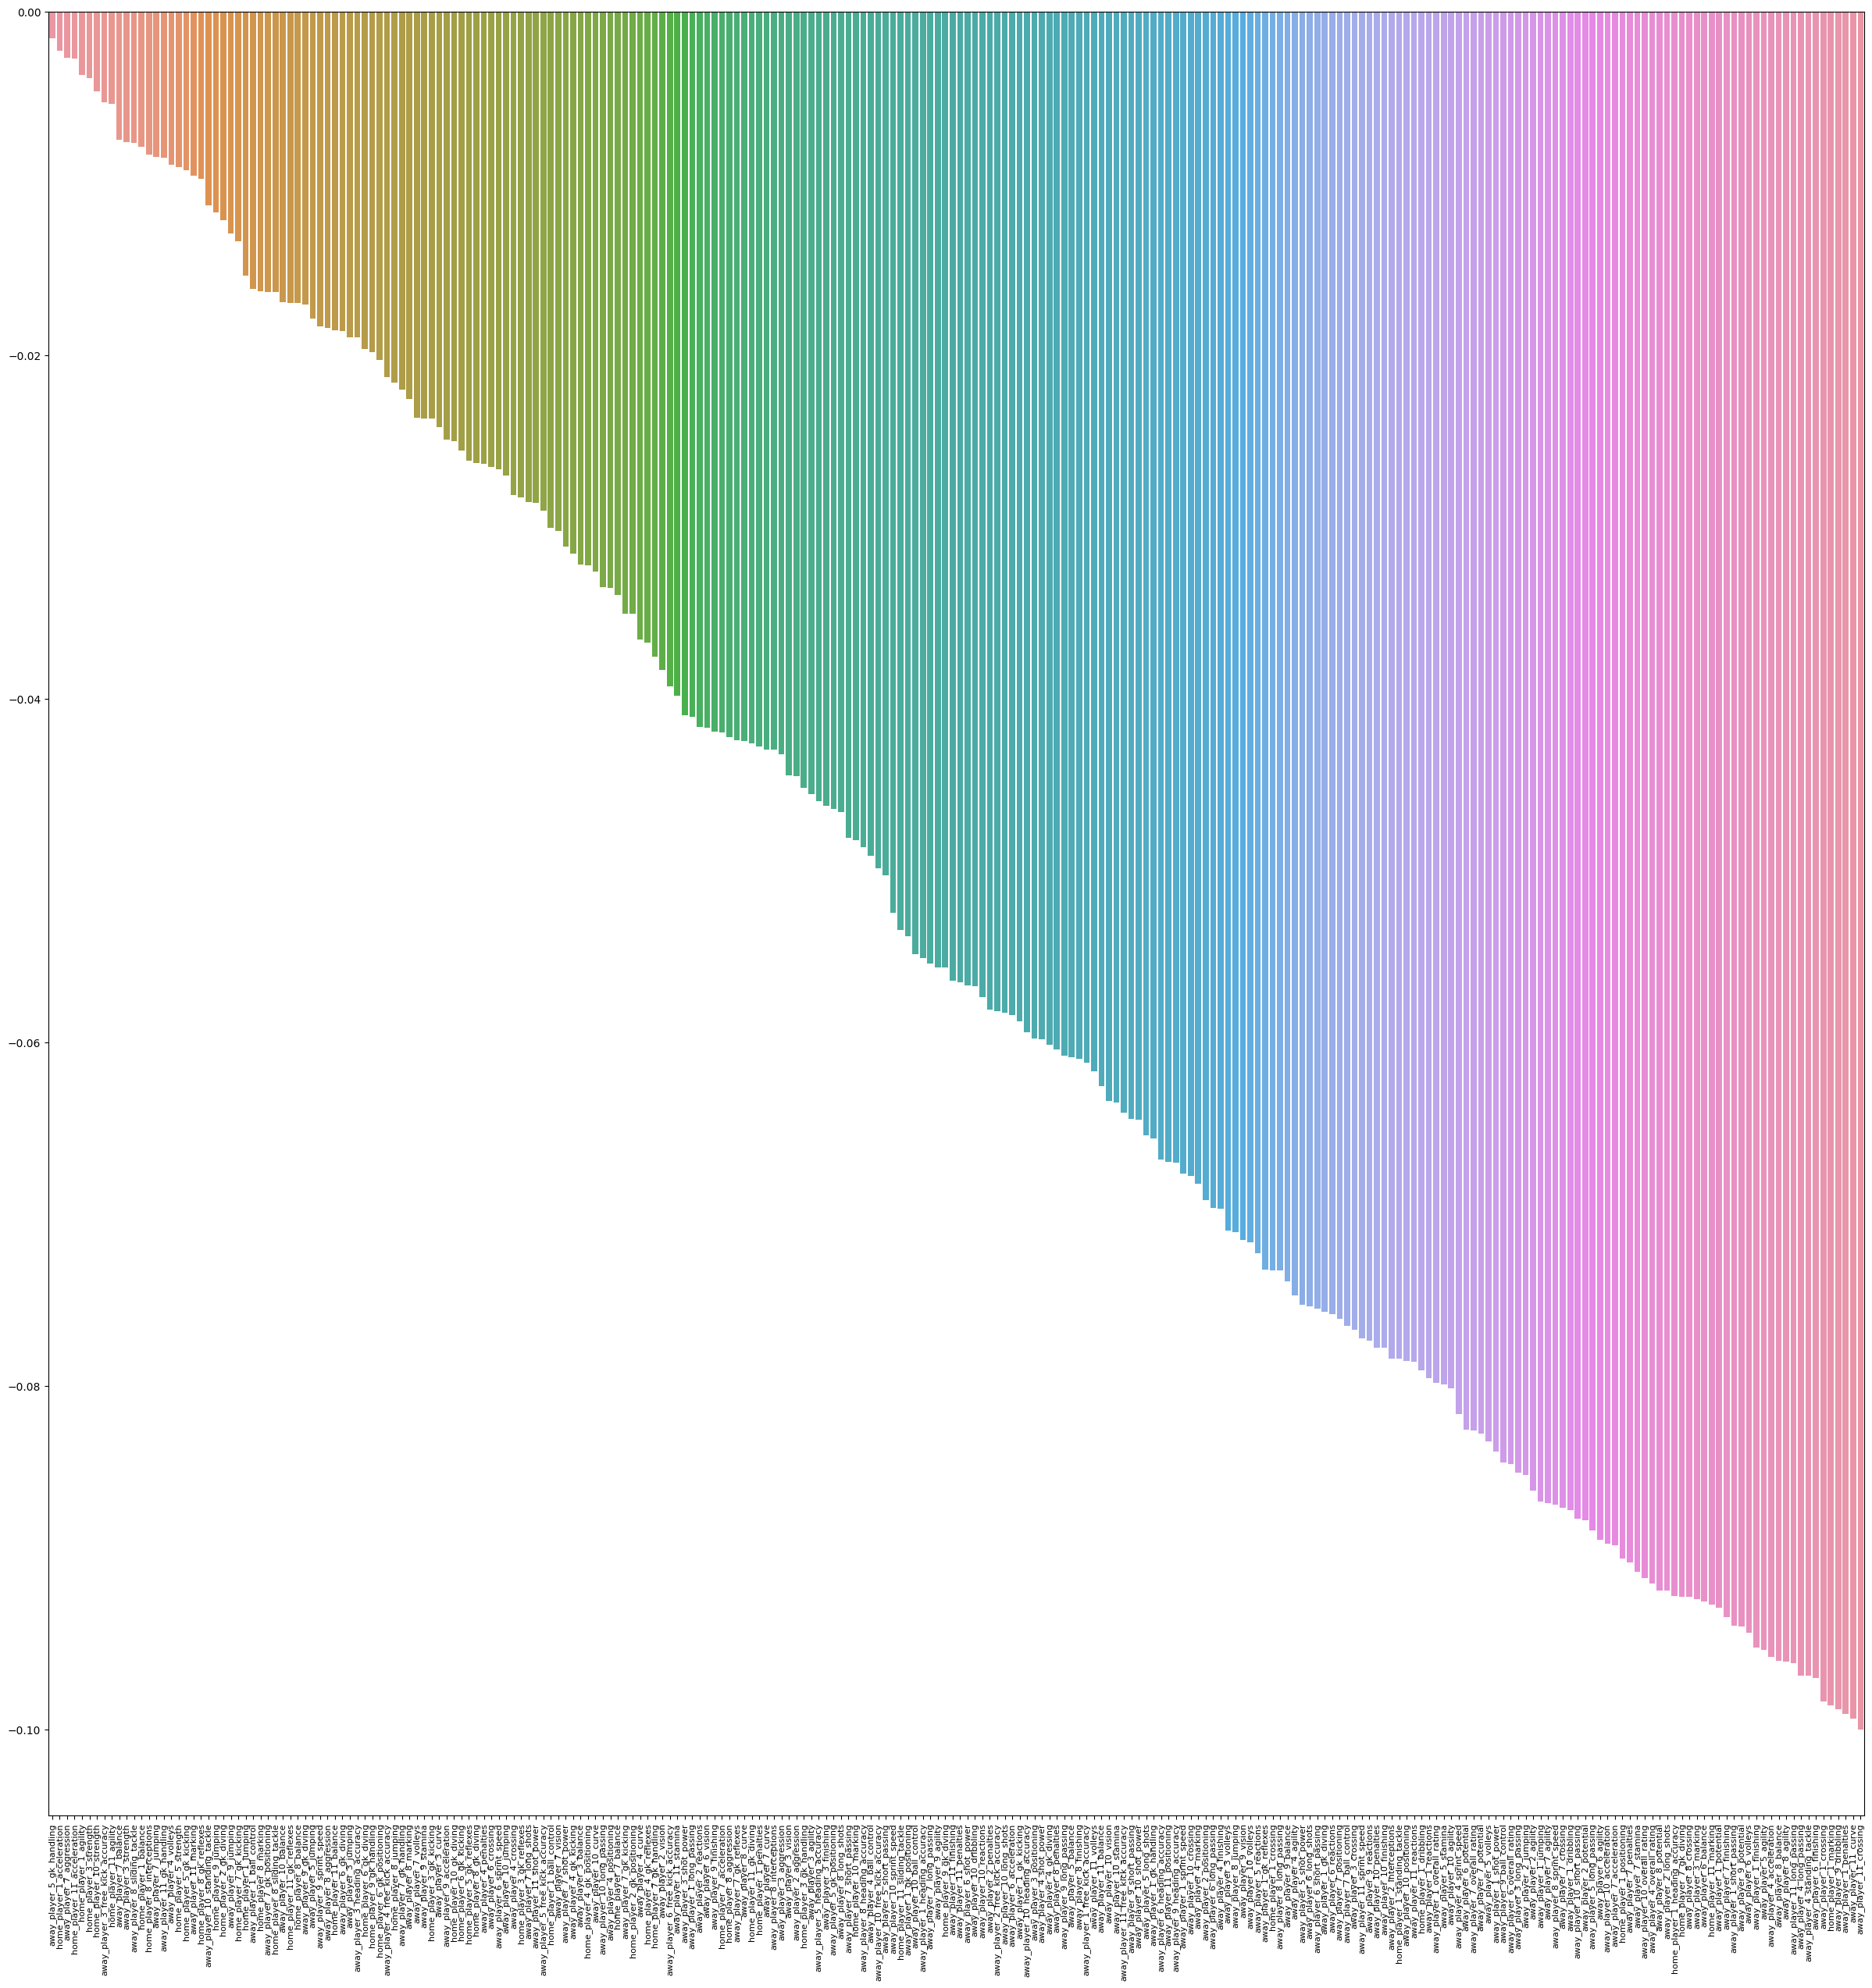

In [1691]:
# draw graph of the least important features with the outcome column for negative values
plt.rc('xtick', labelsize=8)
plt.figure(figsize=(30, 30))
sns.barplot(x=desc_player['low_corr_outcome'][desc_player['low_corr_outcome'] < 0].index, y=desc_player['low_corr_outcome'][desc_player['low_corr_outcome'] < 0].values)
plt.xticks(rotation=90)
plt.show()

### Identifying Patterns and Insights

As we can see from the graphs, the most common match outcome is `home_win` with 45% of the matches. The least common match outcome is `draw` with 24% of the matches. The `away_win` outcome is in the middle with 31% of the matches.

As seen from the correlation matrix, the strongest relationship with the match outcome in the team attributes is `buildUpPlaySpeed` with 0.17. The weakest relationship is `defenceAggression` with 0.02.

As for the weakest relationship, the weakest relationship in the team attributes is `defenceAggression` with 0.02. The strongest relationship is `buildUpPlaySpeed` with 0.17.

## Prediction

In this section, we will use machine learning techniques to predict the match outcome using the betting odds, the team and player attributes. We will compare the performance of different models and evaluate their accuracy.

### Model Definition

In [1692]:
def get_feature_type(df: pd.DataFrame):
    """
    Get the feature type (binary, nominal, continuous) of the features in the dataframe

    Roadmap:
    1. Get the feature type of the features in the dataframe
    2. Split the features into binary, nominal and continuous features
    3. Return the feature type of the features in the dataframe

    """

    # get the feature type of the features in the dataframe
    feature_type = df.dtypes
    print(f'The feature types are split into binary, nominal and continuous features. \n')

    # split the features into binary, nominal and continuous features
    # if there are no features of a certain type, the feature type will be an empty dataframe
    if feature_type[feature_type == 'bool'].empty:
        binary = []
    else:
        # get a list of the binary feature column names
        binary = feature_type[feature_type == 'bool'].index.tolist()

    if feature_type[feature_type == 'object'].empty:
        nominal = []
    else:
        # get a list of the nominal feature column names
        nominal = feature_type[feature_type == 'object'].index.tolist()

    if feature_type[feature_type == 'float64'].empty:
        continuous = []
    else:
        # get a list of the continuous feature column names
        continuous = feature_type[feature_type == 'float64'].index.tolist()
        
    print(f'The binary features are: \n'
        f'{binary} \n')
    print(f'The nominal features are: \n'
        f'{nominal} \n')
    print(f'The continuous features are: \n'
        f'{continuous} \n')

    # return the feature type of the features in the dataframe
    return binary, nominal, continuous

In [1693]:
# get train and test data for each dataframe
def get_train_test_data(df: pd.DataFrame, n: float, Seed: int):
    """
    This function splits the data into train and test data.
    
    Roadmap:
    1. Get the features and the outcome
    2. Split the data into train and test data
    3. Return the features and the outcome with the train and test data

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to split into train and test data.

    Returns
    -------
    X : pandas dataframe
        The features of the dataframe.
    y : pandas series
        The outcome of the dataframe.
    X_train : pandas dataframe
        The features of the train data.
    X_test : pandas dataframe
        The features of the test data.
    y_train : pandas dataframe
        The outcome of the train data.
    y_test : pandas dataframe
        The outcome of the test data.
    """
    
    # get the features
    X = df.drop('outcome', axis=1)
    # get the outcome
    y = df['outcome']
    
    print(f'The features and the target are extracted from the dataframe. \n')
    print(f'The shape of the features is: {X.shape}')
    print(f'The shape of the target is: {y.shape}')

    # split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n, random_state=Seed)
    print(f'The data is split into train and test data with a test size of {n} and a random state of {Seed}. \n')

    return X, y, X_train, X_test, y_train, y_test

In [1694]:
def processor(X: pd.DataFrame, y: pd.Series, binary: list, nominal: list, continuous: list):
    """
    This function processes the dataframes.

    Roadmap:
    1. Build a processing pipeline
    2. Fit the pipeline on the train data
    3. Transform the train and test data
    4. Return the processed dataframe

    Parameters
    ----------
    X : pandas dataframe
        The features of the dataframe.
    y : pandas series
        The outcome of the dataframe.
    binary : list
        The binary features of the dataframe.
    nominal : list
        The nominal features of the dataframe.
    continuous : list
        The continuous features of the dataframe.

    Returns
    -------
    df_proc : pandas dataframe
        The processed dataframe.
    results : pandas dataframe
        The results of the grid search.
    """
    
    
    # feed the train and test data into the pipeline (column transformer). 
    # If there are no features of a certain type, the feature type will be an empty dataframe

    preprocessor = ColumnTransformer([
        ("nominal", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False), nominal + binary),
        ("continuous", Normalizer(), continuous),
        ],
        verbose_feature_names_out=False
    )
    print(f'Features data is fed into the pipeline (column transformer). \n')



    # fit the pipeline on the data
    X_proc = preprocessor.fit_transform(X, y)
    print(f'The pipeline is fit transformed on the data. \n')

    # write the result of the pipeline in a dataframe
    df_proc = pd.DataFrame(X_proc, columns=preprocessor.get_feature_names_out())
    print(f'The result of the pipeline is written in a dataframe. \n')
    print(df_proc.info())

    return df_proc, preprocessor

In [1695]:
def grid_search(X_train: pd.DataFrame, y_train: pd.Series, pipe: Pipeline, params: list):
    """
    This function performs a grid search on the data.
    
    """

    # create a gridsearch
    grid = GridSearchCV(
        pipe, params, scoring="accuracy", n_jobs=-1
    )

    # fit the gridsearch
    grid.fit(X_train, y_train)

    # print the scores
    results = pd.DataFrame(grid.cv_results_)

    # order the results by the rank_test_score
    results = results.sort_values(by="rank_test_score")
    
    print(f'The GridSearchCV is fit on the data. \n')
    print(results[["param_clf", "mean_test_score", "rank_test_score"]])
    print("------------------------------------------")

    return results


In [1696]:
def tt_fit(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, pipe: Pipeline):

    """
    This function trains the data.

    Roadmap:
    ----------
    1. Fit the train data
    2. Score the test data
    3. Predict the test data
    4. Return the score, confusion matrix and classification report

    Parameters
    ----------
    X_train : pandas dataframe
        The features of the train data.
    y_train : pandas series
        The outcome of the train data.
    X_test : pandas dataframe
        The features of the test data.
    y_test : pandas series
        The outcome of the test data.
    preprocessor : ColumnTransformer
        The data preprocessor to use.
    params : list
        The clf parameters to use.
    pipe : Pipeline
        The pipeline to use.

    Returns
    -------
    scores : float
        The score of the test data.
    cm : pandas dataframe
        The confusion matrix of the test data.
    cr : pandas dataframe
        The classification report of the test data.
    """
    
    print(f"{pipe['clf']}")
    print("Training:")
    %timeit %memit pipe.fit(X_train, y_train)
    
    print("------") 
    print("Scoring:")
    %timeit %memit pipe.score(X_test, y_test)
    print("------------------------------------------")
    
    # score the test data
    scores = pipe.score(X_test, y_test)
    print(f'The score is stored. \n')

    # make a prediction
    y_pred = pipe.predict(X_test)

    # make a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'The confusion matrix is stored. \n')

    # make a classification report
    cr = classification_report(y_test, y_pred)
    print(f'The classification report is stored. \n')

    # return the scores, confusion matrix and classification report
    return scores, cm, cr

In [1697]:
def run(dfs: list, n: int, Seed: int):
    """
    This function runs the whole pipeline.

    Roadmap:
    ----------
    1. Get the feature type of the features in the dataframe
    2. Get train and test data for each dataframe
    3. Process the dataframes and get the results
    4. Do a grid search
    5. Fit the data and the models
    6. Return the scores, confusion matrix and classification report

    Parameters
    ----------
    dfs : list
        The dataframes to use.
    n : int
        The ratio of number of samples to use.
    Seed : int
        The seed to use.

    Returns
    -------
    results_dict : dict
        The scores, confusion matrix and classification report of the data.
    """
    # dictate the clf parameters
    params = [
        {
            "clf": [
                GaussianNB(),
                LogisticRegression(),
                KNeighborsClassifier(),
                RandomForestClassifier()
                ],
        },
    ]

    results_dict = {}

    for df in dfs:

        print(f"Dataframe: {df.name}")
        print("------------------------------------------")

        # create a pipeline
        pipe = Pipeline(
            [
                ("pre", "passthrough"),
                ("clf", "passthrough")
            ],
            memory=memory
        )

        # get train and test data for each dataframe
        X, y, X_train, X_test, y_train, y_test = get_train_test_data(df, n, Seed)

        # get the feature type of the features in the dataframe
        binary, nominal, continuous = get_feature_type(X)

        # process the dataframes and get the results
        proc_df, preprocessor = processor(X, y, binary, nominal, continuous)

        # change the preprocessor in the pipeline
        pipe.set_params(pre=preprocessor)

        # do a grid search
        results = grid_search(X_train, y_train, pipe, params)

        # get the best parameters from the grid search
        pipe.set_params(clf=results["param_clf"].iloc[0])
        print(f'The best clf selected is: {pipe["clf"]}. \n')

        # fit the data and the models
        scores, cm, cr = tt_fit(X_train, y_train, X_test, y_test, pipe)

        # store everything in a dictionary
        results_dict[df.name] = {
            "results": results,
            "scores": scores,
            "cm": cm,
            "cr": cr
        }

        print ("------------------------------------------------------------------------------------")
    
    return results_dict

In [1704]:
def evaluatin(name: str, scores: float, cm: pd.DataFrame, cr: pd.DataFrame):
    """
    This function evaluates the model.

    Roadmap:
    ----------
    1. Create a dataframe with the scores
    2. Create a dataframe with the confusion matrix
    3. Create a dataframe with the classification report
    4. Return the scores, confusion matrix and classification report

    Parameters
    ----------
    name : str
        The name of the model.
    scores : float
        The score of the test data.
    cm : pandas dataframe
        The confusion matrix of the test data.
    cr : pandas dataframe
        The classification report of the test data.

    Returns
    -------
    scores : float
        The scores of the test data.
    cm : pandas dataframe
        The confusion matrix of the test data.
    cr : pandas dataframe
        The classification report of the test data.
    """

    print(f"The score of the model on the {name} data is: {scores} \n")

    # plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # print the classification report
    print(f"The classification report for {name} is: \n {cr} \n")

    print ("------------------------------------------------------------------------------------")

    # return the scores, confusion matrix and classification report
    return scores, cm, cr

### Model Evaluation

In this section, we will evaluate the performance of the models using the test data.

In [1699]:
# run the pipeline
cln_dfs = [cln_betting, cln_team, cln_player]
cln_results_dict = run(cln_dfs, n, Seed)

Dataframe: betting
------------------------------------------
The features and the target are extracted from the dataframe. 

The shape of the features is: (453, 18)
The shape of the target is: (453,)
The data is split into train and test data with a test size of 0.3 and a random state of 42. 

The feature types are split into binary, nominal and continuous features. 

The binary features are: 
[] 

The nominal features are: 
[] 

The continuous features are: 
['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA'] 

Features data is fed into the pipeline (column transformer). 

The pipeline is fit transformed on the data. 

The result of the pipeline is written in a dataframe. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B365H   453 non-null    float64
 1   B365D   453 n

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

The GridSearchCV is fit on the data. 

                  param_clf  mean_test_score  rank_test_score
1      LogisticRegression()         0.446429                1
3  RandomForestClassifier()         0.432143                2
2    KNeighborsClassifier()         0.400000                3
0              GaussianNB()         0.292857                4
------------------------------------------
The best clf selected is: LogisticRegression(). 

LogisticRegression()
Training:
peak memory: 3334.77 MiB, increment: -0.52 MiB
peak memory: 3305.14 MiB, increment: -20.95 MiB
peak memory: 3335.83 MiB, increment: 0.17 MiB
peak memory: 3331.62 MiB, increment: 0.09 MiB
peak memory: 3335.61 MiB, increment: 0.00 MiB
peak memory: 3335.20 MiB, increment: -0.55 MiB
peak memory: 3210.64 MiB, increment: -102.12 MiB
peak memory: 3335.52 MiB, increment: -1.50 MiB
3.71 s ± 313 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
------
Scoring:
peak memory: 3335.45 MiB, increment: -0.55 MiB
peak memory: 3331.23 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [34, 35, 50, 58, 59] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 17, 23, 40, 41, 44] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2, 8, 28, 29, 31, 32, 41, 44, 46, 47, 52, 53, 59, 62, 65] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188:

The GridSearchCV is fit on the data. 

                  param_clf  mean_test_score  rank_test_score
3  RandomForestClassifier()         0.490347                1
2    KNeighborsClassifier()         0.355204                2
1      LogisticRegression()         0.336048                3
0              GaussianNB()         0.297059                4
------------------------------------------
The best clf selected is: RandomForestClassifier(). 

RandomForestClassifier()
Training:
peak memory: 3167.36 MiB, increment: -91.45 MiB
peak memory: 3333.08 MiB, increment: -18.06 MiB
peak memory: 3351.75 MiB, increment: 0.00 MiB
peak memory: 3310.47 MiB, increment: 0.03 MiB
peak memory: 3349.83 MiB, increment: 0.05 MiB
peak memory: 3306.14 MiB, increment: -42.45 MiB
peak memory: 3351.19 MiB, increment: 0.25 MiB
peak memory: 3350.89 MiB, increment: 0.03 MiB
4.07 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
------
Scoring:
peak memory: 3351.28 MiB, increment: 0.20 MiB
peak memory: 334

The score of the model on the betting data is: 0.5294117647058824 



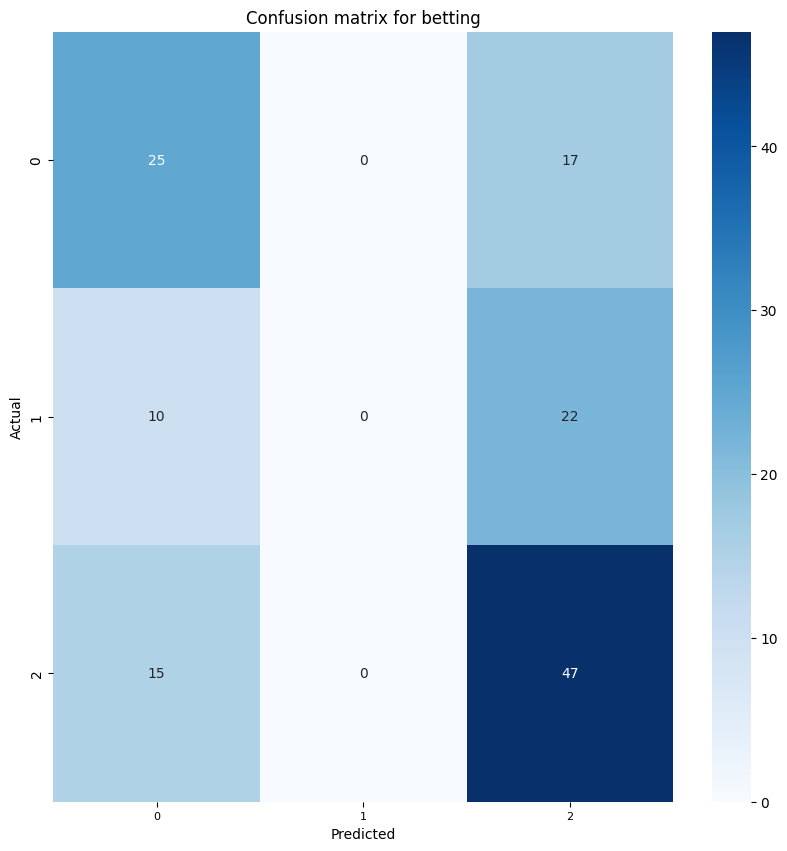

The classification report for betting is: 
               precision    recall  f1-score   support

        -1.0       0.50      0.60      0.54        42
         0.0       0.00      0.00      0.00        32
         1.0       0.55      0.76      0.64        62

    accuracy                           0.53       136
   macro avg       0.35      0.45      0.39       136
weighted avg       0.40      0.53      0.46       136
 

------------------------------------------------------------------------------------
The score of the model on the team data is: 0.371900826446281 



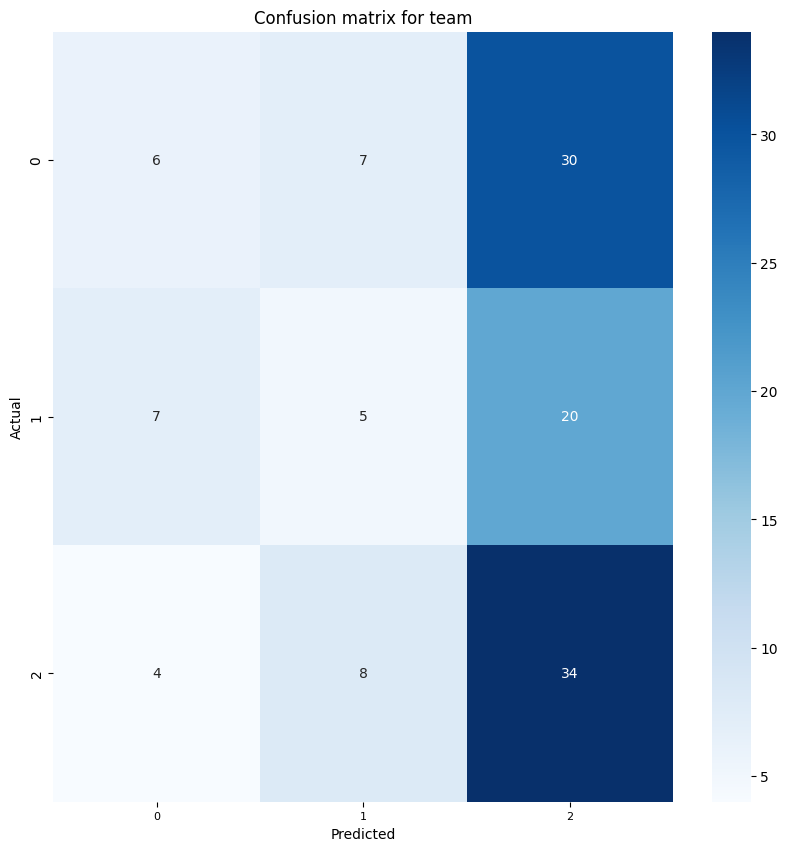

The classification report for team is: 
               precision    recall  f1-score   support

        -1.0       0.35      0.14      0.20        43
         0.0       0.25      0.16      0.19        32
         1.0       0.40      0.74      0.52        46

    accuracy                           0.37       121
   macro avg       0.34      0.34      0.31       121
weighted avg       0.35      0.37      0.32       121
 

------------------------------------------------------------------------------------
The score of the model on the player data is: 0.42857142857142855 



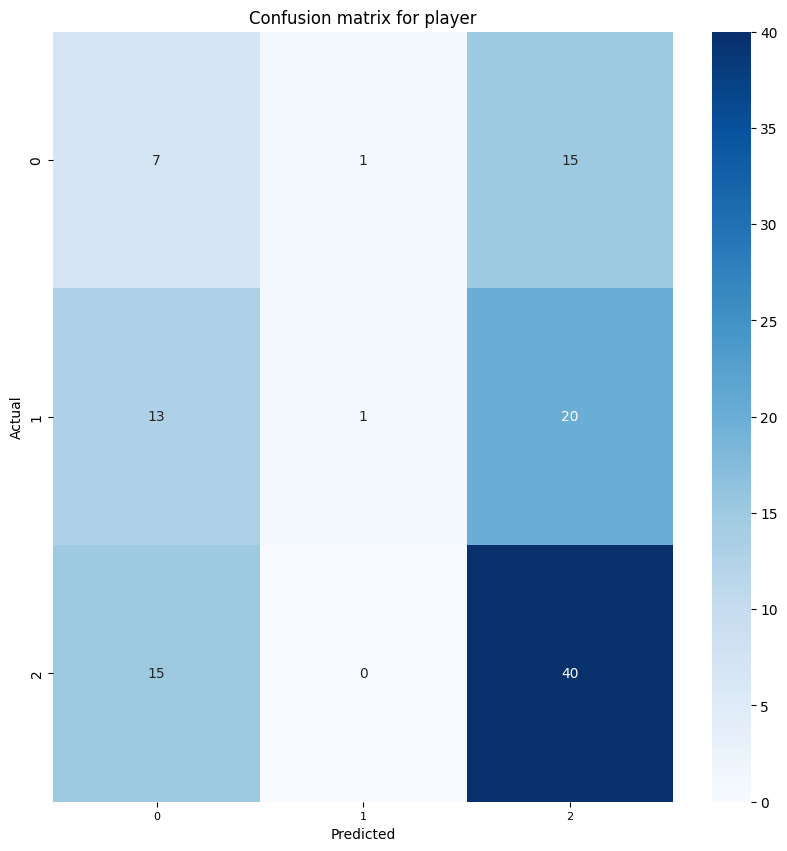

The classification report for player is: 
               precision    recall  f1-score   support

        -1.0       0.20      0.30      0.24        23
         0.0       0.50      0.03      0.06        34
         1.0       0.53      0.73      0.62        55

    accuracy                           0.43       112
   macro avg       0.41      0.35      0.30       112
weighted avg       0.45      0.43      0.37       112
 

------------------------------------------------------------------------------------


In [1707]:
# get the scores, confusion matrix and classification report for each dataframe
for df in cln_dfs:
    name = df.name
    scores = cln_results_dict[name]["scores"]
    cm = cln_results_dict[name]["cm"]
    cr = cln_results_dict[name]["cr"]

    # evaluate the model
    scores, cm, cr = evaluatin(name, scores, cm, cr)

## Conclusion

### Discussion

### Limitations

### Future Work